In [30]:
!python --version
import os
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

from dask.distributed import LocalCluster
cluster = LocalCluster()          # Fully-featured local Dask cluster
client = cluster.get_client()

client

Python 3.10.16


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 7
Total threads: 28,Total memory: 62.58 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46613,Workers: 7
Dashboard: http://127.0.0.1:8787/status,Total threads: 28
Started: Just now,Total memory: 62.58 GiB
Comm: tcp://127.0.0.1:38361,Total threads: 4
Dashboard: http://127.0.0.1:39027/status,Memory: 8.94 GiB
Nanny: tcp://127.0.0.1:43021,


In [1]:
import pandas as pd
import numpy as np
import xarray as xr
xr.set_options(file_cache_maxsize=10)

import scipy as scipy
from scipy import stats
import math
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import proplot as plot
import cartopy.crs as ccrs
import seaborn as sns

import shapefile as shp
from shapely.geometry import Point, Polygon
import shapely
from geopy.distance import distance, Distance, lonlat

from matplotlib import font_manager
font_manager.findfont("TeX Gyre Heros")
mpl.rcParams.update({'font.sans-serif':'TeX Gyre Heros',
                    'font.weight': 'normal',
                    'axes.labelweight': 'normal',
                    'axes.titleweight': 'normal',
                    'pdf.fonttype':42,
                    'ps.fonttype':42
                     })

import string
import os
import requests
import io
from tqdm import tqdm
import time
import h5py
import scipy.io

In [2]:
plt.style.use('dark_background')

In [3]:
# set the path to local folder other than github
login_name = os.getlogin()
### 1.4.1 Local path on PC
local_documents_path = f'/home/{login_name}/Documents' ### this is the path when code is run on Linux

### 1.4.2 Path to github folder
gitpath_idx = os.getcwd().find('nutrient-effect-on-TEX')+len('nutrient-effect-on-TEX')
local_github_path = os.getcwd()[:gitpath_idx]

### 1.4.3 Path to OneDrive folder
local_onedrive_path = f'/home/{login_name}/OneDrive'

In [4]:
def label_pvalues(x):
    if x<0.001:
        return r'$\it{P}$<.001'
    elif x<0.01:
        return r'$\it{P}$<.01'
    elif x<0.05:
        return r'$\it{P}$<.05'
    elif x<0.1:
        return r'$\it{P}$<.1'
    elif x>=0.1:
        return r'$\it{P}$>.1'
    
from matplotlib.colors import Normalize
class FlatCenterNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, center=0, plateau_width=0.025, clip=False):
        self.center = center
        self.plateau_width = plateau_width
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Process input value(s)
        result, is_scalar = self.process_value(value)
        vmin, vmax = self.vmin, self.vmax
        # Map values in a piecewise linear fashion:
        # vmin --> 0, (center - plateau) --> 0.5, (center + plateau) --> 0.5, vmax --> 1
        mapped = np.ma.masked_array(np.interp(result, 
                    [vmin, self.center - self.plateau_width, self.center + self.plateau_width, vmax],
                    [0, 0.5, 0.5, 1]))
        if is_scalar:
            mapped = mapped[0]
        return mapped


In [5]:
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds04_gridded_coretop_tex.nc'
gridded_coretop_ds = xr.open_dataset(os.path.join(fpath,fname))
gridded_coretop_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    region_ID      (lon, lat) float64 ...
    tex_count      (lon, lat) float64 ...
    tex_median     (lon, lat) float64 ...
    tex_mean       (lon, lat) float64 ...
    tex_std        (lon, lat) float64 ...
    tex_residuals  (lon, lat) float64 ...
Attributes:
    title:             Gridded coretop TEX86 data
    long_name:         statistics of TEX86 for each grid cell with the same l...
    units:             TEX86 [unitless], thermocline-integrated T [degC], dep...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    processing_level:  Derived product
    history:           Computed from the global compilation of core-top GDGT ...
    references:        This study

In [6]:
### ocean properties dataset
fpath = fr'{local_github_path}/netcdf_files'
fname = 'ds06_calculated_ocean_properties.nc'
ocean_properties_ds = xr.open_dataset(os.path.join(fpath,fname),decode_times=False)
ocean_properties_ds

<xarray.Dataset>
Dimensions:        (lat: 720, lon: 1440)
Coordinates:
  * lat            (lat) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * lon            (lon) float32 -179.9 -179.6 -179.4 ... 179.4 179.6 179.9
Data variables:
    no3_sf2tc_avg  (lat, lon) float32 ...
    no3_tc         (lat, lon) float32 ...
    t_sf2tc_avg    (lat, lon) float32 ...
    tc_depth       (lat, lon) float32 ...
    t_tc           (lat, lon) float32 ...
Attributes:
    title:             Calculated Ocean Properties: Nitrite and Temperature f...
    summary:           This dataset contains climatological annual means (199...
    data_sources:      Global Ocean Biogeochemistry Hindcast (CMEMS); World O...
    Conventions:       CF-1.7
    processing_level:  Derived product
    history:           (a) Nitrate: Calculated climatological annual means (1...
    references:        CMEMS, WOA23

In [7]:
fpath = fr'{local_github_path}/spreadsheets'
fname = 'ds03_processed_coretop_tex.csv'

coretop_df = pd.read_csv(f'{fpath}/{fname}')
coretop_df

,sampleID,index_column,core_name,core_type,sample_depth_start,sample_depth_end,Latitude,Longitude,modernWaterDepth,TEX86,...,thermocline_depth,thermocline_T,thermocline_T_depthIntegral,SSN,thermocline_nitrate,thermocline_nitrate_depthIntegral,region_ID,regionName,pred_tex,tex_residuals
0,RR00001,JET_RR_00001,GeoB7702-3,GC,5.0,6.0,31.651700,34.07330,562.0,0.662000,...,55.0,19.006910,21.589685,0.088246,0.003865,0.025728,NaN,NaN,0.593260,0.068740
1,RR00002,JET_RR_00002,KNR195-5-5 MC11,MC,6.0,8.0,-1.532700,-86.78520,2288.0,0.602873,...,25.0,20.861510,22.520248,4.094641,8.300386,5.318187,10.0,East Equatorial Pacific,0.603206,-0.000333
2,RR00003,JET_RR_00003,KNR195-5-6 MC12,MC,0.0,1.0,-3.710500,-81.11530,378.0,0.570000,...,15.0,20.730000,22.093159,3.517715,5.804398,4.208444,NaN,NaN,0.598641,-0.028641
3,RR00004,JET_RR_00004,KNR195-5-7 MC16,MC,0.0,1.0,-3.750200,-81.13580,379.0,0.572000,...,15.0,20.583000,22.041553,4.415240,7.112034,5.378340,NaN,NaN,0.598090,-0.026090
4,RR00005,JET_RR_00005,KNR195-5-8 MC18,MC,4.0,6.0,-3.969000,-81.31000,1024.0,0.599447,...,15.0,20.119310,21.319408,4.326240,6.462469,4.969550,10.0,East Equatorial Pacific,0.590371,0.009076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2077,RR02080,JET_RR_02080,AMD17_176_BC,NaN,NaN,NaN,69.600000,-65.40000,267.0,0.400000,...,10.0,-0.879210,-0.630935,3.086211,3.155563,3.107517,60.0,Baffin Bay,0.355749,0.044251
2078,RR02081,JET_RR_02081,AMD17_8.1_BC,NaN,NaN,NaN,69.410000,-64.40000,1054.0,0.322581,...,10.0,-0.841310,-0.534860,2.976617,3.043328,2.995078,60.0,Baffin Bay,0.356776,-0.034195
2079,RR02082,JET_RR_02082,AMD17_Disko_Fan_BC,NaN,NaN,NaN,67.970000,-59.49000,1012.0,0.375000,...,10.0,0.088910,0.324683,2.783790,2.829360,2.795761,60.0,Baffin Bay,0.365963,0.009037
2080,RR02083,JET_RR_02083,DSDP591_0-3cm_PC,PC,0.0,3.0,-31.584330,164.44867,2131.0,0.671171,...,65.0,19.653900,20.455896,0.494959,0.917937,0.575588,61.0,Tasman Sea,0.581141,0.090030


In [8]:
t_sf2tc_da = ocean_properties_ds['t_sf2tc_avg']
thermocline_nitrate_da = ocean_properties_ds['no3_sf2tc_avg']
thermocline_depth_da = ocean_properties_ds.tc_depth

In [9]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_coretop_published_130307.mat'

mat_cortop = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_cortop.keys())
print(mat_cortop['__header__'])

df_tmp = []
features = ['name','region','ref',
            'lat','lon','depth','d15N',]
for i in range(len(mat_cortop['ctop_pub'][0][0][0])):
    for feature in features:
        if ('name' in feature) or ('region' in feature) or ('ref' in feature):
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0][0]
            except:
                sel_feature = np.nan
        else:
            try:
                sel_feature = (mat_cortop['ctop_pub'][feature][0][0][i])[0]
            except:
                sel_feature = np.nan
        df_tmp.append(sel_feature)
        

### convert df_tmp into a dataframe with 7 columns
coretop_d15N_df = pd.DataFrame(np.reshape(df_tmp, (2176,7)),columns=features)
coretop_d15N_df

### covert datatype of columns
coretop_d15N_df = coretop_d15N_df.astype({'lat':float,'lon':float,'depth':float,'d15N':float})
coretop_d15N_df


dict_keys(['__header__', '__version__', '__globals__', 'ctop_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 20:13:16 2013'


,name,region,ref,lat,lon,depth,d15N
0,ODP 1228,Eastern Pacific,Agnihotri et al. (2006),-11.064167,-78.077833,273.0,5.3506
1,ODP 1229,Iberian Margin,Alt-Epping et al. (2007),38.634500,-9.454200,NaN,5.6000
2,ODP 1230,Iberian Margin,Alt-Epping et al. (2007),38.625000,-9.508300,102.0,5.8000
3,ODP 1231,Iberian Margin,Alt-Epping et al. (2007),38.692200,-9.260600,19.0,6.3000
4,ODP 1232,Iberian Margin,Alt-Epping et al. (2007),38.646110,-9.424170,54.0,6.1000
...,...,...,...,...,...,...,...
2171,EW0408-084 MC-7,Gulf of Alaska,Walinsky et al. (2009),59.530000,-144.130000,686.0,3.3000
2172,EW0408-091 MC-8,Gulf of Alaska,Walinsky et al. (2009),59.650000,-145.150000,198.0,2.5000
2173,EW0408-094 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.660000,-147.710000,744.0,3.7000
2174,EW0408-097 MC-8,Gulf of Alaska,Walinsky et al. (2009),60.560000,-146.770000,401.0,4.2000


In [10]:
### gridded coretop d15N
mid_lat_array = thermocline_depth_da.lat.values
mid_lon_array = thermocline_depth_da.lon.values

coretop_d15N_df['match_lat'] = [mid_lat_array[np.abs(mid_lat_array-lat).argmin()] for lat in coretop_d15N_df['lat']]
coretop_d15N_df['match_lon'] = [mid_lon_array[np.abs(mid_lon_array-lon).argmin()] for lon in coretop_d15N_df['lon']]

features = ['match_lat','match_lon','d15N']
pregridded_coretop_d15N_df = coretop_d15N_df[features]
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.dropna().reset_index(drop=True)

new_features = ['d15N_count','d15N_median','d15N_mean','d15N_std']
agg_func_list = ['count','median','mean','std']
for i, new_feature in enumerate(features):
    pregridded_coretop_d15N_df[new_features[i]] = pregridded_coretop_d15N_df.groupby([
        'match_lat','match_lon'])['d15N'].transform(agg_func_list[i])
    
pregridded_coretop_d15N_df = pregridded_coretop_d15N_df.drop_duplicates(
    subset=['match_lat','match_lon'],keep='first').reset_index(drop=True)

coretop_gridded_d15N_da = xr.Dataset.from_dataframe(pregridded_coretop_d15N_df.set_index(['match_lat','match_lon']))
coretop_gridded_d15N_da = coretop_gridded_d15N_da.rename({'match_lon':'lon','match_lat':'lat'})
## nan mask
# coretop_gridded_d15N_da = coretop_gridded_d15N_da.where(coretop_gridded_d15N_da['d15N_count']>1)
coretop_gridded_d15N_da

    
### combine all dataarrays into a single dataset
SST_da = thermocline_depth_da
coretop_gridded_d15N_ds = xr.merge([SST_da,coretop_gridded_d15N_da]).drop_vars(['tc_depth','d15N'])
coretop_gridded_d15N_ds

<xarray.Dataset>
Dimensions:      (lat: 720, lon: 1440)
Coordinates:
  * lat          (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon          (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Data variables:
    d15N_count   (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_median  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan
    d15N_mean    (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan nan

0.31, $\it{P}$<.001
r2 score = 0.0500496478997936
-0.17, $\it{P}$<.001
best_window_size = 19
-0.31, $\it{P}$<.001


/tmp/ipykernel_5731/751109017.py:165: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
/tmp/ipykernel_5731/751109017.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
/tmp/ipykernel_5731/751109017.py:175: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis

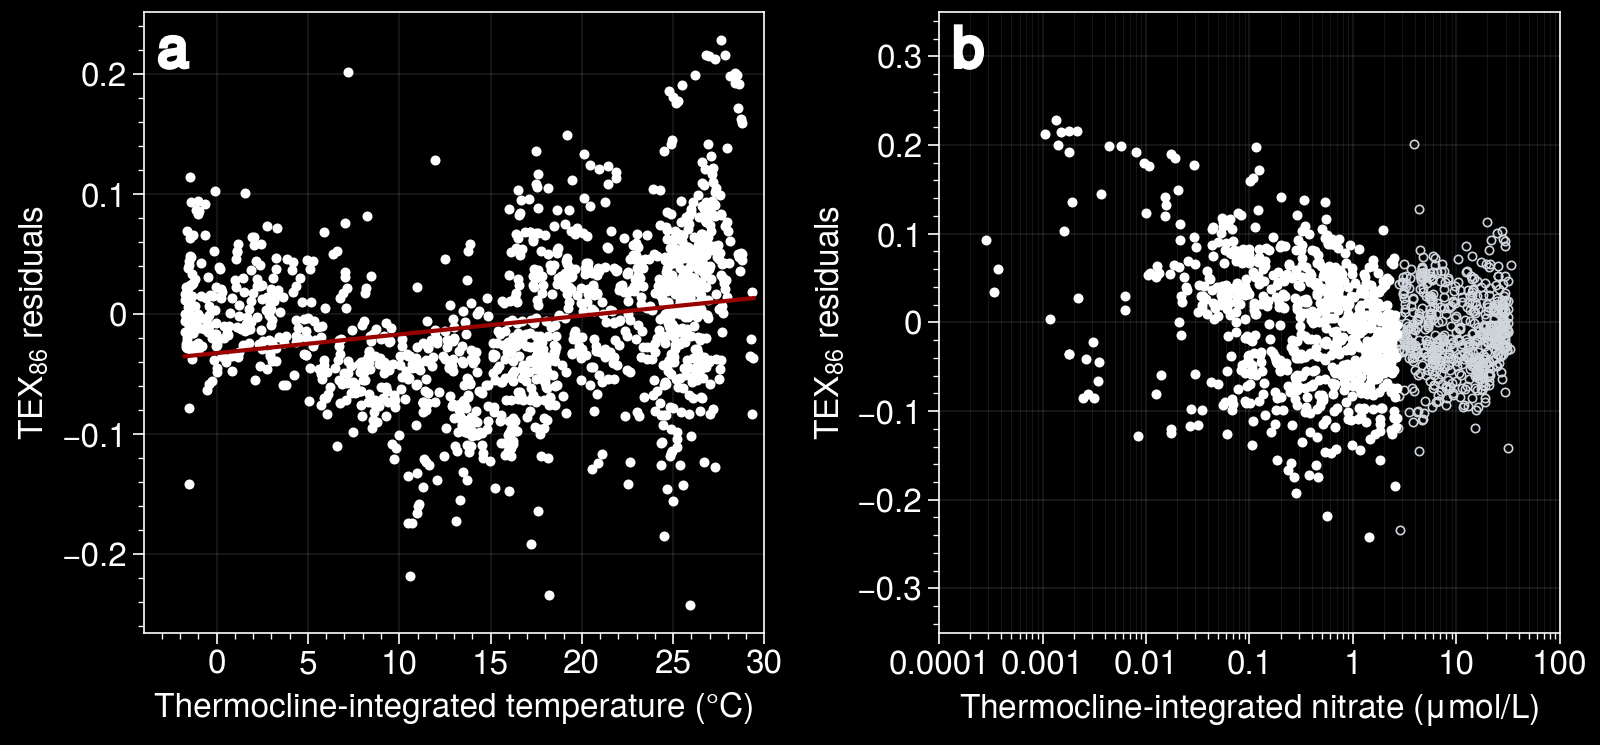

In [ ]:
plot.rc['meta.color'] = 'w'
plot.rc['abc.color'] = 'w'
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(ncols=2,width=8,share=False)

axs.format(fontsize=12)

ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$ residuals'
)
plot_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg',
                                                  'tex_median']).reset_index()
plot_x = plot_data['t_sf2tc_avg']
# plot_y = plot_data['tex_median']
plot_y = plot_data['tex_residuals']
norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           m='.',
           c='w',
        #    norm=norm,
        #    cmap='burd',
           zorder=2,label='Included data')

# plot_data = plot_coretop[plot_coretop['lat']>70].dropna(subset=['t_sf2tc_avg','tex_median'])
# plot_x = plot_data['t_sf2tc_avg']
# plot_y = plot_data['tex_median']
# ax.scatter(plot_x,plot_y,
#            m='.',c='none',
#            mec='gray4',zorder=1,
#            label='Excluded data')

# plot_x = exclude_coretop['thermocline_T_depthIntegral']
# plot_y = exclude_coretop['TEX86']
# ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg','tex_residuals'])
reg_data2 = reg_data.dropna(subset=['t_sf2tc_avg','tex_residuals'])
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_residuals']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_residuals'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
# ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='top')

h, l = ax.get_legend_handles_labels()
# ax.legend(h,l,loc='lr',ncols=1,frameon=False,fontcolor='w')
ax.format(
        # ylim=(0.1,0.95),
        # yticks=np.arange(0.1,1,0.2),
        xlim=(-4,30),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=['no3_sf2tc_avg','tex_residuals'])
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
#         transform=ax.transAxes,
#         ha='right',va='top',
#         c='gray1')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,101,1)
score_list = []
pval_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
        pval_list.append(pval)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
# ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
# ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
#         ha='right',va='top',
#         rotation=90)
# ax.plot(10**log_x,y_running_mean,c='k',lw=1)

plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           marker='.',
           color='w',
        #    norm=norm,
        #    cmap='burd',
           label='Coretops')


plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=[sel_x_param,sel_y_param])
plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
ax.scatter(plot_x_exclude,plot_y_exclude,
            marker='.',color='none',
            mec='gray4',
            label='Excluded data',zorder=0)


reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
# ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
#         label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.02,0.02,
#         f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    xgridminor=True,
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
)
#########################################################################################
axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20,
                                                    'abc.weight':'normal',},
           facecolor='none',
           gridcolor='w')


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_plot_residuals.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)

0.31, $\it{P}$<.001
r2 score = 0.0500496478997936
-0.17, $\it{P}$<.001
best_window_size = 19
-0.31, $\it{P}$<.001


/tmp/ipykernel_5731/2012672481.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
/tmp/ipykernel_5731/2012672481.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
/tmp/ipykernel_5731/2012672481.py:178: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

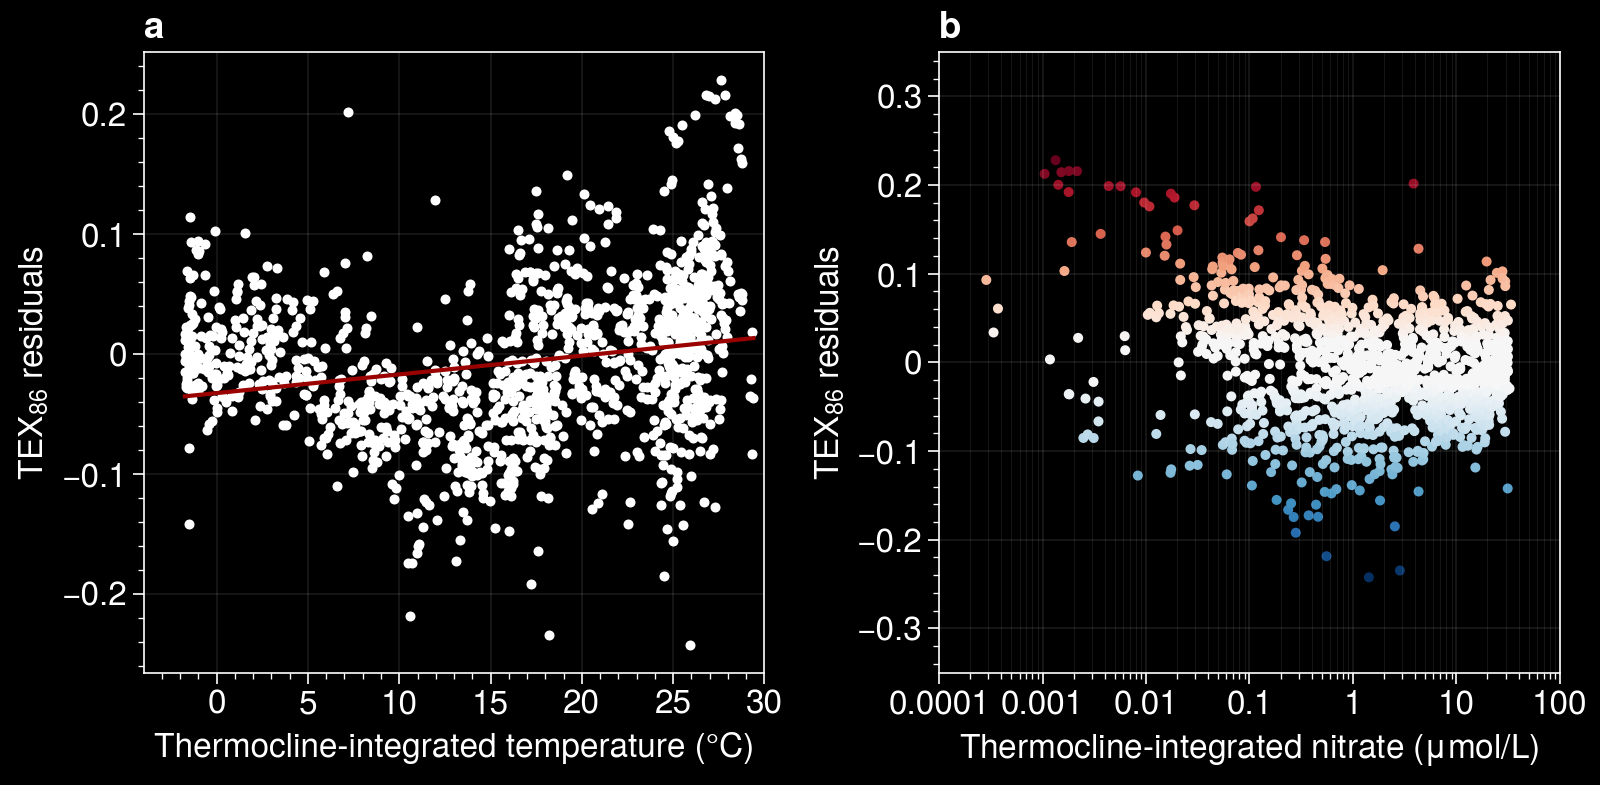

In [ ]:
plot.rc['meta.color'] = 'w'
plot.rc['abc.color'] = 'w'
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(ncols=2,width=8,share=False)

axs.format(fontsize=12)

ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$ residuals'
)
plot_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg',
                                                  'tex_median']).reset_index()
plot_x = plot_data['t_sf2tc_avg']
# plot_y = plot_data['tex_median']
plot_y = plot_data['tex_residuals']
norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           m='.',
           c='w',
        #    norm=norm,
        #    cmap='burd',
           zorder=2,label='Included data')

# plot_data = plot_coretop[plot_coretop['lat']>70].dropna(subset=['t_sf2tc_avg','tex_median'])
# plot_x = plot_data['t_sf2tc_avg']
# plot_y = plot_data['tex_median']
# ax.scatter(plot_x,plot_y,
#            m='.',c='none',
#            mec='gray4',zorder=1,
#            label='Excluded data')

# plot_x = exclude_coretop['thermocline_T_depthIntegral']
# plot_y = exclude_coretop['TEX86']
# ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg','tex_residuals'])
reg_data2 = reg_data.dropna(subset=['t_sf2tc_avg','tex_residuals'])
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_residuals']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_residuals'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
# ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='top')

h, l = ax.get_legend_handles_labels()
# ax.legend(h,l,loc='lr',ncols=1,frameon=False,fontcolor='w')
ax.format(
        # ylim=(0.1,0.95),
        # yticks=np.arange(0.1,1,0.2),
        xlim=(-4,30),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=['no3_sf2tc_avg','tex_residuals'])
# plot_data = plot_coretop_no3.dropna(subset=['no3_sf2tc_avg','tex_residuals'])
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
#         transform=ax.transAxes,
#         ha='right',va='top',
#         c='gray1')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,101,1)
score_list = []
pval_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
        pval_list.append(pval)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
# ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
# ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
#         ha='right',va='top',
#         rotation=90)
# ax.plot(10**log_x,y_running_mean,c='k',lw=1)

# plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
# plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]
plot_x = pre_reg_data[sel_x_param]
plot_y = pre_reg_data[sel_y_param]

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           marker='.',
           color=plot_y,
           norm=norm,
           cmap='burd',
           label='Coretops')


# plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=[sel_x_param,sel_y_param])
# plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
# plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
# ax.scatter(plot_x_exclude,plot_y_exclude,
#             marker='.',color='none',
#             mec='gray4',
#             label='Excluded data',zorder=0)


reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
# ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
#         label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.02,0.02,
#         f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    xgridminor=True,
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
)
#########################################################################################
# axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20,
#                                                     'abc.weight':'normal',},
#            facecolor='none',
#            gridcolor='w')


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_plot_residuals2.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)

0.90, $\it{P}$<.001
r2 score = 0.7639197678579358
-0.17, $\it{P}$<.001
best_window_size = 19
-0.31, $\it{P}$<.001


/tmp/ipykernel_5731/3373911971.py:168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
/tmp/ipykernel_5731/3373911971.py:169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
/tmp/ipykernel_5731/3373911971.py:178: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

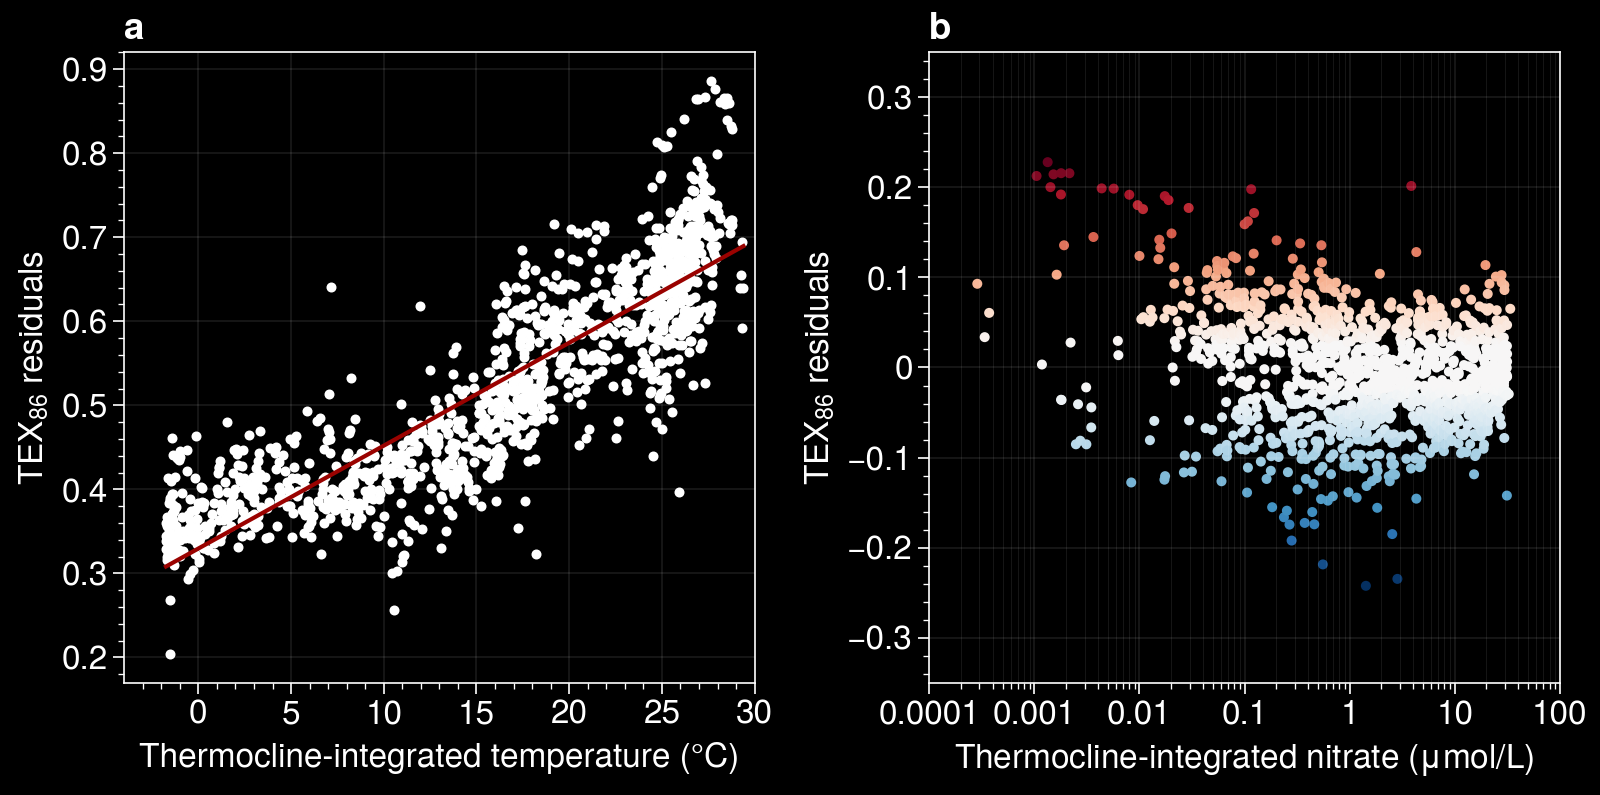

In [ ]:
plot.rc['meta.color'] = 'w'
plot.rc['abc.color'] = 'w'
def running_mean_log10(x, y, window_size):
        # Convert x to log10 scale
        log_x = np.log10(x)
        
        # Create a DataFrame with log_x and y
        df = pd.DataFrame({'log_x': log_x, 'y': y})
        
        # Sort the DataFrame by log_x
        df = df.sort_values(by='log_x')
        
        # Calculate the running mean of y with the specified window size
        df['y_running_mean'] = df['y'].rolling(window=window_size, center=True).mean()
        
        return df['log_x'], df['y_running_mean']


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(ncols=2,width=8,share=False)

axs.format(fontsize=12)

ax = axs[0]
ax.format(
    xlabel='Thermocline-integrated temperature (\N{DEGREE SIGN}C)',
    ylabel='TEX$_{86}$ residuals'
)
plot_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg',
                                                  'tex_median']).reset_index()
plot_x = plot_data['t_sf2tc_avg']
plot_y = plot_data['tex_median']
# plot_y = plot_data['tex_residuals']
norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           m='.',
           c='w',
        #    norm=norm,
        #    cmap='burd',
           zorder=2,label='Included data')

# plot_data = plot_coretop[plot_coretop['lat']>70].dropna(subset=['t_sf2tc_avg','tex_median'])
# plot_x = plot_data['t_sf2tc_avg']
# plot_y = plot_data['tex_median']
# ax.scatter(plot_x,plot_y,
#            m='.',c='none',
#            mec='gray4',zorder=1,
#            label='Excluded data')

# plot_x = exclude_coretop['thermocline_T_depthIntegral']
# plot_y = exclude_coretop['TEX86']
# ax.scatter(plot_x,plot_y,m='.',c='gray4',zorder=0,label='')

reg_data = plot_coretop[plot_coretop['lat']<70].dropna(subset=['t_sf2tc_avg','tex_median'])
reg_data2 = reg_data.dropna(subset=['t_sf2tc_avg','tex_median'])
ols_tex_thermoT_thisStudy = LinearRegression()
XX = reg_data2['t_sf2tc_avg']
yy = reg_data2['tex_median']
ols_tex_thermoT_thisStudy.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols_tex_thermoT_thisStudy.predict(XX_sample.reshape(-1,1))
ax.plot(XX_sample,yy_pred,c='deep red')
rho, pval = spearmanr(reg_data2['t_sf2tc_avg'],reg_data2['tex_median'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
### add linear regression equation as text in axs[0]
slope_text = f'{ols_tex_thermoT_thisStudy.coef_[0]:.3f}'
intercept_text = f'{ols_tex_thermoT_thisStudy.intercept_:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ T$_{{sf2tc}}$ + {intercept_text}'

print(f'r2 score = {ols_tex_thermoT_thisStudy.score(XX.values.reshape(-1,1),yy)}')
pval_label = label_pvalues(pval)
# ax.text(0.10,0.98,f'$\\rho$={rho:.2f}, {pval_label}\n(Gridded coretops; N={len(reg_data2)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='top')

h, l = ax.get_legend_handles_labels()
# ax.legend(h,l,loc='lr',ncols=1,frameon=False,fontcolor='w')
ax.format(
        # ylim=(0.1,0.95),
        # yticks=np.arange(0.1,1,0.2),
        xlim=(-4,30),
)
#########################################################################################
ax = axs[1]

plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=['no3_sf2tc_avg','tex_residuals'])
# plot_data = plot_coretop_no3.dropna(subset=['no3_sf2tc_avg','tex_residuals'])
reg_data = plot_data
reg_data['log_thermocl_depthIntg_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
reg_data['log_thermocl_depthIntg_nitrate'] = reg_data['log_thermocl_depthIntg_nitrate'].replace([-np.inf,np.inf],np.nan)
ols = LinearRegression()
XX = reg_data['log_thermocl_depthIntg_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red',ls='--')
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.98,0.98,f'$\\rho$={rho:.2f}\n{pval_label}\n(Gridded\ncoretops;\nN={len(reg_data)})',
#         transform=ax.transAxes,
#         ha='right',va='top',
#         c='gray1')

sel_x_param = 'no3_sf2tc_avg'
sel_y_param = 'tex_residuals'
### linear fit between log(nitrate) and TEX residuals
pre_reg_data = plot_data
pre_reg_data = pre_reg_data.sort_values(by=sel_x_param).reset_index(drop=True)

### determine best window size
window_size = np.arange(5,101,1)
score_list = []
pval_list = []
for sel_window_size in window_size:
        log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],sel_window_size)
        lowno3_threshold_tmp = 10**log_x[y_running_mean.idxmin()]
        reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold_tmp]
        rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
        score_list.append(rho)
        pval_list.append(pval)
best_window_size = window_size[np.argmin(score_list)]
# best_window_size = 100
print(f'best_window_size = {best_window_size}')
### find x value with minimum running mean of y
log_x, y_running_mean = running_mean_log10(pre_reg_data[sel_x_param],pre_reg_data[sel_y_param],best_window_size)
# ax.axvline(10**log_x[y_running_mean.idxmin()],color='gray5',ls='--',lw=1,zorder=0)
lowno3_threshold = np.round(10**log_x[y_running_mean.idxmin()],decimals=1)
# ax.text(lowno3_threshold-0.1,0.99,f'{lowno3_threshold:.1f} $\mu$mol/L',transform=ax.get_xaxis_transform(),
#         ha='right',va='top',
#         rotation=90)
# ax.plot(10**log_x,y_running_mean,c='k',lw=1)

# plot_x = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_x_param]
# plot_y = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold][sel_y_param]
plot_x = pre_reg_data[sel_x_param]
plot_y = pre_reg_data[sel_y_param]

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
ax.scatter(plot_x,plot_y,
           marker='.',
           color=plot_y,
           norm=norm,
           cmap='burd',
           label='Coretops')


# plot_data = plot_coretop_no3[plot_coretop_no3['lat']<70].dropna(subset=[sel_x_param,sel_y_param])
# plot_x_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_x_param]
# plot_y_exclude = plot_data[plot_data[sel_x_param]>lowno3_threshold][sel_y_param]
# ax.scatter(plot_x_exclude,plot_y_exclude,
#             marker='.',color='none',
#             mec='gray4',
#             label='Excluded data',zorder=0)


reg_data = pre_reg_data[pre_reg_data[sel_x_param]<lowno3_threshold]

reg_data['log_'+sel_x_param] = np.log10(reg_data[sel_x_param])
reg_data['log_'+sel_x_param] = reg_data['log_'+sel_x_param].replace([-np.inf,np.inf],np.nan)
reg_data = reg_data.dropna(how='any',subset=[sel_x_param,sel_y_param,'log_'+sel_x_param])
ols = sm.OLS(reg_data[sel_y_param],sm.add_constant(reg_data['log_'+sel_x_param])).fit()
plot_x_fit = np.linspace(reg_data['log_'+sel_x_param].min(),reg_data['log_'+sel_x_param].max(),100)
plot_y_fit = ols.predict(sm.add_constant(plot_x_fit))
# ax.plot(10**plot_x_fit,plot_y_fit,c='deep red',
#         label='TEX residuals')

### print regression equation
slope_text = f'{ols.params[1]:.3f}'
intercept_text = f'{ols.params[0]:.3f}'
equation_text = f'TEX$_{{86}}$ = {slope_text} $\cdot$ log$_{{10}}$[Nitrate] + {intercept_text}'

rho, pval = spearmanr(reg_data[sel_x_param],reg_data[sel_y_param])
pval_label = label_pvalues(pval)
print(f'{rho:.2f}, {pval_label}')
# ax.text(0.02,0.02,
#         f'$\\rho$={rho:.2f}, {pval_label}\n(data with nitrate < {lowno3_threshold:.1f} $\mu$mol/L; N={len(reg_data)})\n{equation_text}',
#         transform=ax.transAxes,
#         ha='left',va='bottom')



ax.format(
    xscale='log',
    xlim=(1e-4,1e2),
    xgridminor=True,
    ylim=(-0.35,0.35),
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
)
#########################################################################################
# axs.format(abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20,
#                                                     'abc.weight':'normal',},
#            facecolor='none',
#            gridcolor='w')


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_plot_residuals2.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)

/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_5731/2084074364.py:15: ProplotWarning: Got conflicting or duplicate keyword args: {'latlocator': [-60, -30, 0, 30, 60], 'latlines': 30}. Using the first one.
  ax.format(land=True, landcolor='gray4',landzorder=0,
/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "embed_fonts" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)


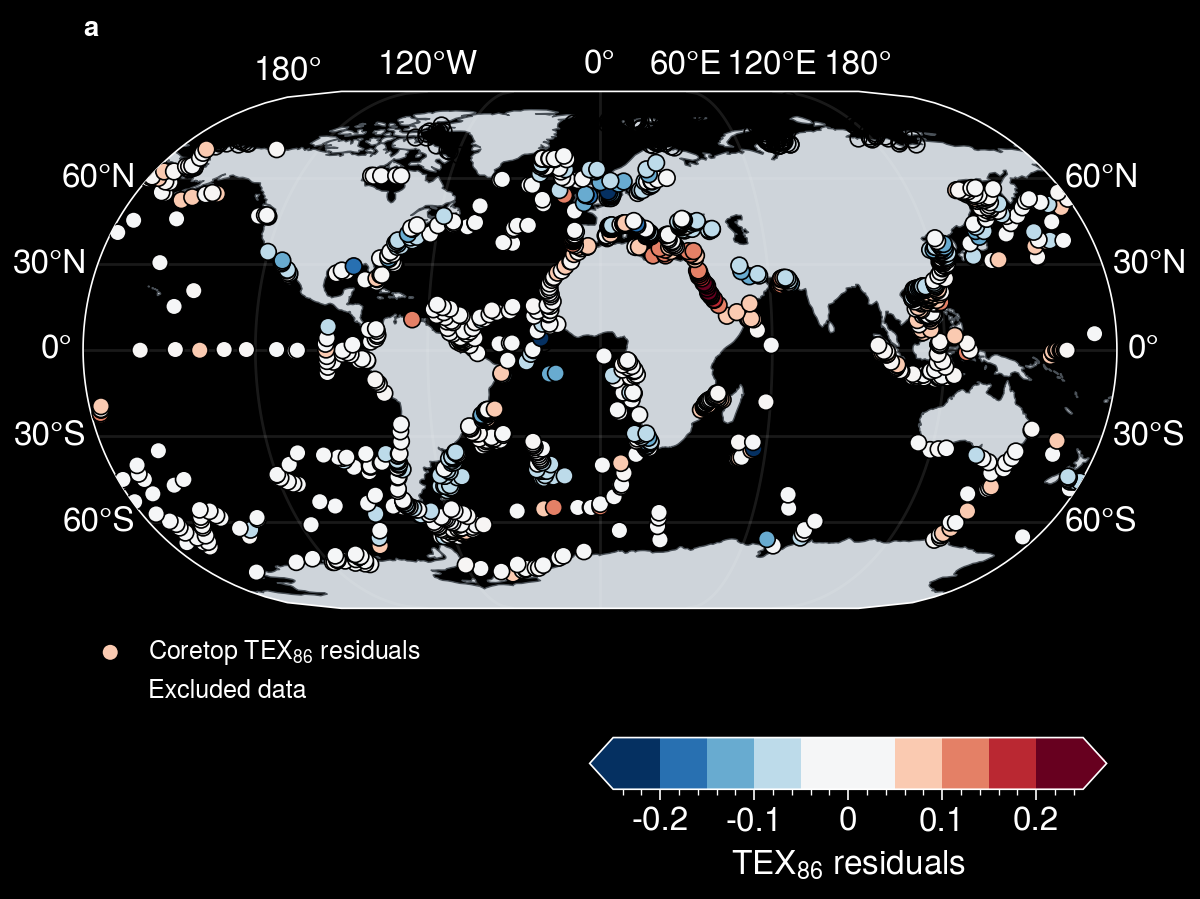

In [ ]:
plot.rc['meta.color'] = 'w'


plot_coretop = xr.merge([gridded_coretop_ds,t_sf2tc_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','t_sf2tc_avg']).reset_index(drop=True)
plot_coretop_no3 = xr.merge([gridded_coretop_ds,thermocline_nitrate_da]
                        ).to_dataframe().reset_index().dropna(subset=['tex_residuals','no3_sf2tc_avg']).reset_index(drop=True)

exclude_coretop = coretop_df[coretop_df['QC_flag']=='exclude']


fig, axs = plot.subplots(proj='eck3',width=6)

ax = axs[0]
ax.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='lr', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlines=30,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray1',
        coastlinewidth=0.5,
        coastzorder=1,
        labelsize=12)
# ##### plot a contour line of thermocline-integrated nitrate at lowno3_threshold μM
# m = thermocline_nitrate_da.plot.contourf(ax=ax,levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
#                                         cmap='matter',alpha=0.8,
#                                         add_colorbar=False,robust=True,
#                                         label=None,rasterized=True)

# axins1 = inset_axes(
#     ax,
#     width="50%",
#     height="10%",
#     loc="lower right",
#     bbox_to_anchor=(-0.01,-0.05,1,1),
#     bbox_transform=ax.transAxes,
#     borderpad=0,
# )

# axins1.patch.set_alpha(0)
# cbar = fig.colorbar(m,
#              cax=axins1,
#              orientation="horizontal",)
# cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=12)
# cbar.ax.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
# cbar.ax.tick_params(labelsize=12,labelcolor='w')
# m2 = thermocline_nitrate_da.plot.contour(ax=ax,levels=[0,lowno3_threshold],
#                                                  linewidths=0.5,
#                                                  linestyles='dashed',
#                                                  colors='w',robust=True)
# cbar.add_lines(m2)
# cbar.lines[0].set_linestyle('dashed')

ax.set_title('')
###### plot tex residuals on map

plot_x = exclude_coretop['Longitude']
plot_y = exclude_coretop['Latitude']
ax.scatter(plot_x,plot_y,m='o',mec='k',facecolor='none',zorder=2,label='')

plot_data = plot_coretop[plot_coretop['lat']>70][['lon','lat','tex_median']].dropna(subset=['tex_median'])
plot_x = plot_data['lon']
plot_y = plot_data['lat']
ax.scatter(plot_x,plot_y,
           m='o',mec='k',facecolor='none',zorder=2,
           label='Excluded data')

plot_data = plot_coretop[plot_coretop['lat']<70][['lon','lat','tex_residuals']].dropna()
plot_x = plot_data['lon']
plot_y = plot_data['lat']
plot_c = plot_data['tex_residuals']

norm = FlatCenterNormalize(vmin=-0.2, vmax=0.2, center=0, plateau_width=0.025)
m=ax.scatter(plot_x,plot_y,
           c=plot_c, 
           norm=norm,
           mec='k',
           levels=10,
        #    levels=np.arange(-0.2,0.21,0.02),
           transform=ccrs.PlateCarree(),
           m='o',cmap='burd',
           label='Coretop TEX$_{86}$ residuals',
           zorder=3)

h,l = axs[0].get_legend_handles_labels()

ax.legend(h[::-1],l[::-1],loc='lower left',
          fontcolor='w',
          edgecolor='w',
          bbox_to_anchor=(-0.01,-0.21,1,1),
          ncols=1,
          frameon=False)

axins1 = inset_axes(
    ax,
    width="50%",
    height="10%",
    loc="lower right",
    bbox_to_anchor=(-0.01,-0.35,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both')
cbar.set_label('TEX$_{86}$ residuals', size=12)
cbar.ax.tick_params(labelsize=12,labelcolor='w')
cbar.ax.xaxis.set_ticks(np.arange(-0.2,0.21,0.1))
cbar.ax.xaxis.set_ticklabels(['-0.2','-0.1','0','0.1','0.2'])


fpath = fr'{local_github_path}/figures/'
fname = 'nitrate_effect_global_map_noBG.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)


/tmp/ipykernel_5731/3700698599.py:33: ProplotWarning: Calling arbitrary axes methods from SubplotGrid was deprecated in v0.8 and will be removed in a future release. Please index the grid or loop over the grid instead.
  axs.axvline(best_window_size,c='pink9',ls='--',lw=1)
/tmp/ipykernel_5731/3700698599.py:38: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  axs.format(abc=True,abcloc='ur',abcstyle='a',rc_kw={'abc.size':20,'abc.weight':'normal'},)
/tmp/ipykernel_5731/3700698599.py:38: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  axs.format(abc=True,abcloc='ur',abcstyle='a',rc_kw={'abc.size':20,'abc.weight':'normal'},)
/tmp/ipykernel_5731/3700698599.py:38: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in version 0.8.
  axs.format(abc=True,abcloc='ur',abcstyle='a',rc_kw={'abc.size':20,'abc.weight':'normal'},)
/tmp/ipykernel_5731/3700698599.py:38: ProplotWarning: rc setting 'abc.style' was renamed to 'abc' in vers

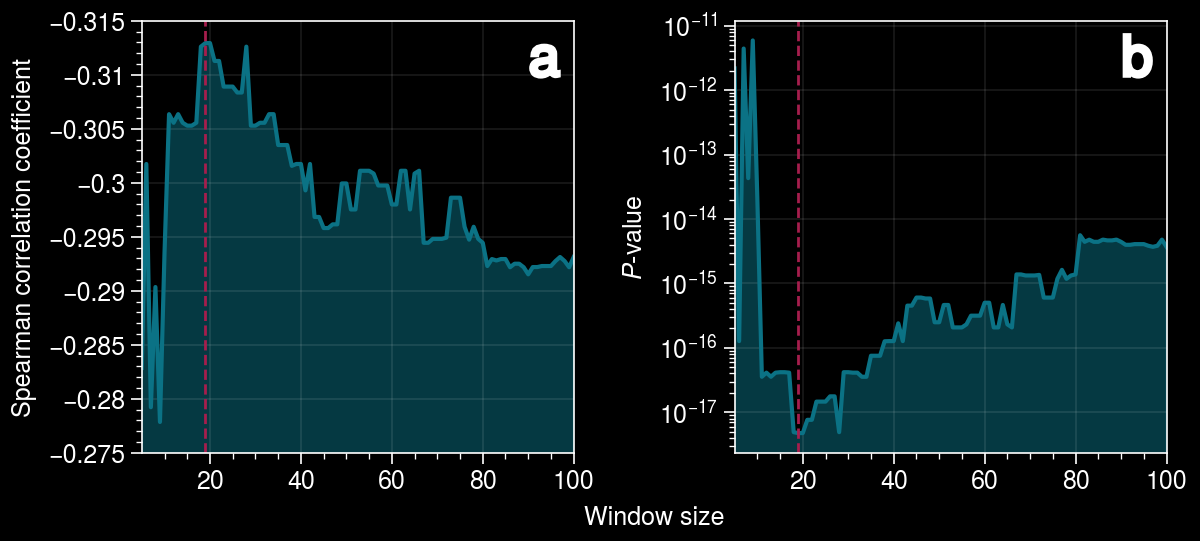

In [15]:
fig, axs = plot.subplots(width=6,ncols=2,sharey=0)
window_size_score_df = pd.DataFrame({'window_size':window_size,
                                     'score':score_list,
                                     'pval':pval_list})

ax = axs[0]
### fill_between y
ax.fill_between(window_size_score_df['window_size'],window_size_score_df['score'],
                color='cyan9',alpha=0.5)
ax.plot(window_size_score_df['window_size'],window_size_score_df['score'],c='cyan9')

ax.format(
    xlabel='Window size',
    ylabel='Spearman correlation coefficient',
    ylim=(-0.275,-0.315)
)

ax = axs[1]
### fill_between y
ax.fill_between(window_size_score_df['window_size'],window_size_score_df['pval'],
                color='cyan9',alpha=0.5)
ax.plot(window_size_score_df['window_size'],window_size_score_df['pval'],c='cyan9')

ax.format(
    xlabel='Window size',
    ylabel=r'$\it{P}$-value',
    yscale='log',
    yformatter='log',
)

#### ax.axvline at the highest score and lowest pval
best_window_size = window_size[np.argmin(score_list)]
axs.axvline(best_window_size,c='pink9',ls='--',lw=1)
# ax.text(best_window_size,0.98,f'{best_window_size}',transform=ax.get_yaxis_transform(),
#         ha='center',va='top',rotation=90)

#########################################################################################
axs.format(abc=True,abcloc='ur',abcstyle='a',rc_kw={'abc.size':20,'abc.weight':'normal'},)

fpath = fr'{local_github_path}/figures/'
fname = 'Fig_S4_sliding_window_scores.pdf'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

# Figure 2

In [16]:
regionName_df = coretop_df.pivot_table(index=('region_ID','regionName'),values='TEX86',aggfunc='count').reset_index()[['region_ID','regionName']]
regionID_to_regionName_dict = dict(zip(regionName_df['region_ID'],regionName_df['regionName']))
regionID_to_regionName_dict


{1.0: 'Amundsen Sea',
 2.0: 'Arabian Sea',
 3.0: 'Arctic Ocean',
 4.0: 'Baltic Sea',
 5.0: 'Bering Sea',
 6.0: 'Black Sea',
 7.0: 'Chilean Offshore',
 8.0: 'Chukchi Sea',
 9.0: 'Drake Passage',
 10.0: 'East Equatorial Pacific',
 11.0: 'Eastern Indian Ocean (Offshore Indonesia)',
 12.0: 'Eastern North America Offshore',
 13.0: 'Eastern South America Offshore',
 14.0: 'Greenland Sea',
 15.0: 'Gulf of Aqaba',
 16.0: 'Gulf of California',
 17.0: 'Gulf of Mexico',
 18.0: 'Hudson Bay',
 19.0: 'Indian Ocean Gyre',
 20.0: 'Indonesian Throughflow',
 21.0: 'Japan Sea',
 22.0: 'Kara Sea',
 23.0: 'Laptev Sea',
 24.0: 'Mediterranean',
 25.0: 'Mozambique Channel',
 26.0: 'North Atlantic',
 27.0: 'North Sea',
 28.0: 'Northern Pacific',
 29.0: 'NZ-SW Pacific',
 30.0: 'Pacific-Southern Ocean',
 31.0: 'Red Sea',
 32.0: 'Ross Sea',
 33.0: 'Santa Barbara Bay',
 34.0: 'SE Pacific',
 35.0: 'Sea of Okhotsk',
 36.0: 'South Africa Offshore',
 37.0: 'South Atlantic Gyre',
 38.0: 'South China Sea',
 39.0: 'South

/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/tmp/ipykernel_5731/1603942975.py:65: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/proplot/figure.py:469: MatplotlibDeprecationWarning: print_figure() got unexpected keyword argument "embed_fonts" which is no longer supported as of 3.3 and will become an error two minor releases later
  return func(self, *args, **kwargs)


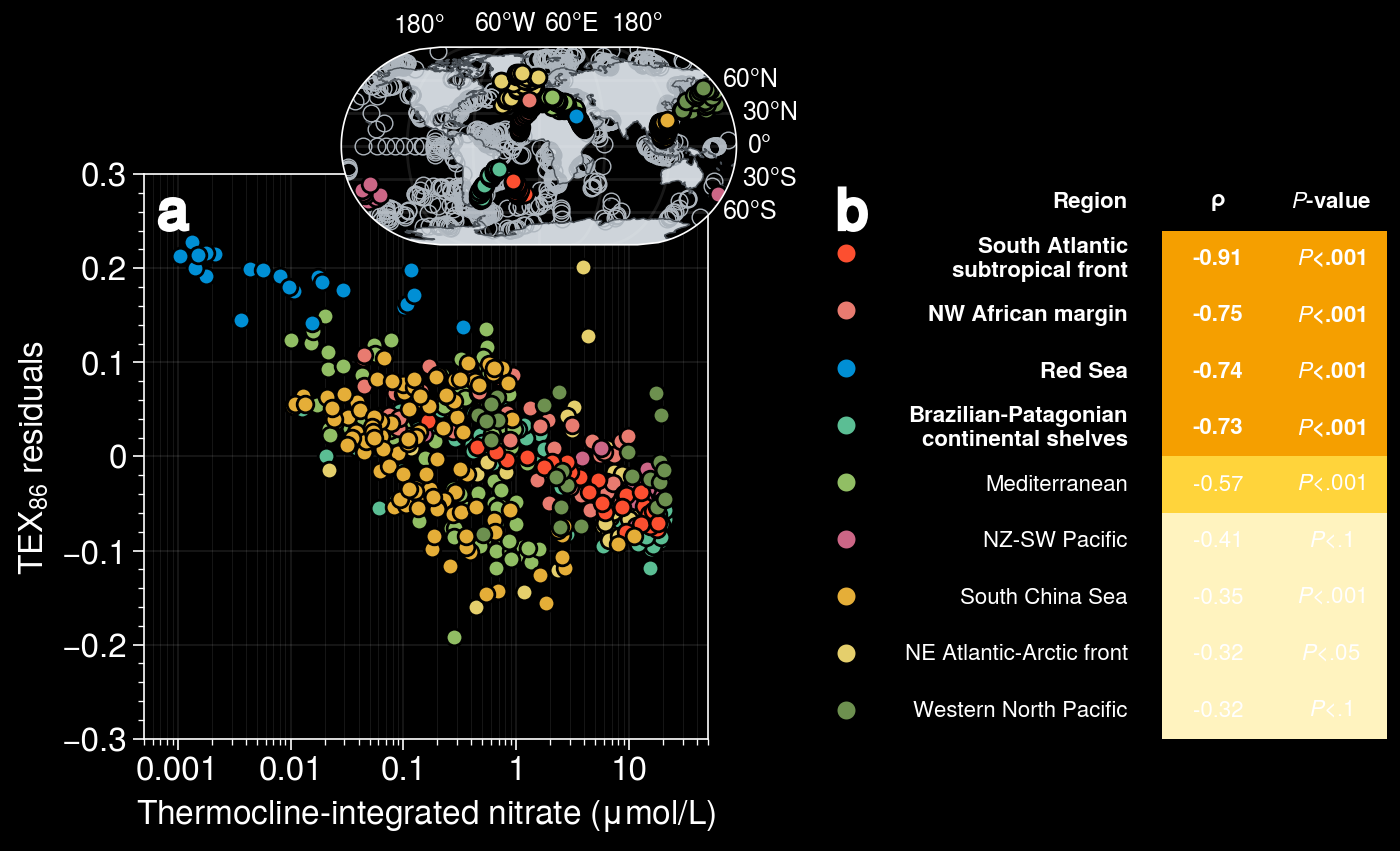

In [ ]:
plot.rc['meta.color'] = 'w'
cyc1 = plot.get_colors('qual1',N=5)
cyc2 = plot.get_colors('538',N=5)

sel_cyc = plot.Cycle(cyc1+cyc2)
### param for plotting
optimal_pval_cutoff = 0.1
nitrate_cutoff = 100

fig, axs = plot.subplots(ncols=2,
                         share=0,
                         width=7)
axs.format(fontsize=12)
plot_data = xr.merge([gridded_coretop_ds,t_sf2tc_da,thermocline_nitrate_da,coretop_gridded_d15N_ds])
plot_gridded_data = plot_data[['lat','lon','t_sf2tc_avg','no3_sf2tc_avg',
                                'tex_median','tex_residuals','tex_std',
                                'd15N_mean','region_ID']].to_dataframe().dropna(subset=['region_ID']).reset_index()
plot_gridded_data['regionName'] = plot_gridded_data['region_ID'].map(regionID_to_regionName_dict)
plot_gridded_data['regionName'] = plot_gridded_data['regionName'].replace({
    'Eastern Indian Ocean (Offshore Indonesia)' : 'Indonesian Offshore',
    'Northern Pacific':'Western North Pacific',
    'Eastern South America Offshore':'Brazilian-Patagonian\ncontinental shelves',
    'South Atlantic Gyre':'South Atlantic\nsubtropical front',
    'Tropical West African Offshore':'NW African margin',
    'North Atlantic':'NE Atlantic-Arctic front',
})

plot_gridded_data = plot_gridded_data[plot_gridded_data['no3_sf2tc_avg']<nitrate_cutoff]

# Create an inset axis overlapping on the top right corner of axs[0]
ax_inset = axs[0].inset_axes([0.35, 0.7, 0.7, 0.7],proj='eck3')

ax_inset.format(land=True, landcolor='gray4',landzorder=0,
        latlabels='r', lonlabels='top',
        gridcolor='w',gridlinewidth=1,
        latlocator=[-60,-30,0,30,60],
        coast=True, coastcolor='gray1',
        coastlinewidth=0.5,
        coastzorder=1,)
grouped = plot_gridded_data.groupby('regionName')

#### calculate rho and pval between tex_residuals and thermocl_depthIntg_nitrate by regions
rho_list = []
pval_list = []
region_name_list = []
for name, group in grouped:
    reg_data = group[['no3_sf2tc_avg', 'tex_residuals']].dropna()
    if len(reg_data) < 10:
        continue
    else:
        rho, pval = spearmanr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        rho_pearson, pval_pearson = pearsonr(reg_data['no3_sf2tc_avg'], reg_data['tex_residuals'])
        region_name_list.append(name)
        rho_list.append(rho)
        pval_list.append(pval)

### build a dataframe to sort by rho
rho_df = pd.DataFrame({'regionName': region_name_list,
                       'rho': rho_list,
                       'pval': pval_list})

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))]

sig_regions_ = rho_df[((rho_df['pval'] < optimal_pval_cutoff)
                       & (rho_df['rho'] < 0))][rho_df['regionName'].isin([
                           'Weddell Sea', 'Arctic Ocean', 'Drake Passage',
                           'Kara Sea', 'Greenland Sea',
                           'Laptev Sea',
                           'Sea of Okhotsk',
                        #    'Eastern South America Offshore_far'
                           ]) == False]
sig_regions_color_dict = dict(zip(sig_regions_['regionName'], plot.get_colors(sel_cyc, N=len(sig_regions_))))

for name, group in grouped:
    ### check rho and pval of each region
    if name not in sig_regions_['regionName'].unique():
        ax_inset.scatter(group['lon'], group['lat'],
                         c='none',
                         mec='gray5', mew=0.5,
                         label=name,
                         zorder=1)
    else:
        rho_ = rho_df[rho_df['regionName'] == name]['rho'].values[0]
        pval_ = rho_df[rho_df['regionName'] == name]['pval'].values[0]

        if (pval_ < optimal_pval_cutoff
            and (rho_ < 0)
            and name != 'Weddell Sea'
            and name != 'Arctic Ocean'
            and name != 'Drake Passage'
            and name != 'Kara Sea'
            and name != 'Greenland Sea'
            and name != 'Laptev Sea'
            and name != 'Sea of Okhotsk'
            # and name != 'Eastern South America Offshore_far'
            ):
            ax_inset.scatter(group['lon'], group['lat'],
                            #  cycle=sel_cyc,
                             c=sig_regions_color_dict.get(name, 'gray5'),
                             mec='k', mew=1,
                             label=name,
                             zorder=2)
            
ax = axs[0]
sig_plot_data = plot_gridded_data[plot_gridded_data['regionName'].isin(sig_regions_['regionName'])]
grouped = sig_plot_data.groupby('regionName')   
for name, group in grouped:
    ### plot data
    ax.scatter(group['no3_sf2tc_avg'],group['tex_residuals'],
                cycle=sel_cyc,
                mec='k',mew=1,
                label=name,
                zorder=2)
    
### add low-nitrate threshold
# ax.axvline(lowno3_threshold,color='gray5',ls='--',lw=1,zorder=0)
### add vertical text 
x_pos = lowno3_threshold
y_pos = -0.29
# ax.text(x_pos,y_pos,f'{lowno3_threshold:.1f} $\mu$mol/L',
#         # transform=ax.get_xaxis_transform(),
#         ha='right',va='bottom',
#         rotation=90)
    
### ols regression of all significant regions
reg_data = sig_plot_data[['no3_sf2tc_avg','tex_residuals']].dropna()
reg_data['Log10_nitrate'] = np.log10(reg_data['no3_sf2tc_avg'])
ols = LinearRegression()
XX = reg_data['Log10_nitrate']
yy = reg_data['tex_residuals']
ols.fit(XX.values.reshape(-1,1),yy)
XX_sample = np.linspace(XX.min(),XX.max(),100)
yy_pred = ols.predict(XX_sample.reshape(-1,1))
# ax.plot(10**XX_sample,yy_pred,c='deep red')
### spearman rho and pval
rho, pval = spearmanr(reg_data['no3_sf2tc_avg'],reg_data['tex_residuals'])
pval_label = label_pvalues(pval)
# ax.text(0.02,0.02,f'$\\rho$={rho:.2f}\n{pval_label}\n(All regions; n={len(reg_data)})',
#         transform=ax.transAxes,
#         ha='left',va='bottom')

### orthoganal distance regression 
X = reg_data['Log10_nitrate']
y = reg_data['tex_residuals']
covx = np.cov(X)
covy = np.cov(y)
odr_dat = scipy.odr.Data(X,y)
def linear_func(B, x):
    '''Linear function y = m*x + b'''
    # B is a vector of the parameters.
    # x is an array of the current x values.
    # x is in the same format as the x passed to Data or RealData.
    #
    # Return an array in the same format as y passed to Data or RealData.
    return B[0]*x + B[1]
odr_func = scipy.odr.Model(linear_func)
odr = scipy.odr.ODR(odr_dat,odr_func,beta0=[-2.,0.2])
out = odr.run()
slope = out.beta[0]
intercept = out.beta[1]
X_pred = np.linspace(X.min(),X.max(),100)
y_pred = linear_func(out.beta,X_pred)
# ax.plot(10**X_pred,y_pred,c='k',ls='--',lw=2,label='ODR fit')

ax.format(
    xlabel='Thermocline-integrated nitrate ($\mu$mol/L)',
    ylabel='TEX$_{86}$ residuals',
    xlim=(5e-4,5e1),
    xscale='log',
    xgridminor=True,
    ylim=(-0.3,0.3),
)


axs.format(
    abc='a',rc_kw={'abc.size':20,'abc.weight':'normal'},abcloc='ul',
)

### plot a table reporting rho and pval of significant regions
table_ax = axs[1]
table_ax.axis('off')
table_data = sig_regions_[['regionName','rho','pval']]

### formatted values to be displayed in the table as 4 significant figures
table_data['rho'] = table_data['rho'].apply(lambda x: f'{x:.2f}')
table_data['pval'] = table_data['pval'].apply(lambda x: f'{x:.4f}')
table_data['pval_labels'] = table_data['pval'].apply(lambda x: label_pvalues(float(x)))
table_data = table_data.rename(columns={'regionName':'Region',
                                        'rho':'$\\rho$',
                                        'pval_labels':r'$\it{P}$-value'})


table_data2 = table_data[['Region','$\\rho$',r'$\it{P}$-value']].sort_values(by='$\\rho$',ascending=False).copy()
### color cell with rho < -0.7
### set header text bold
### set header background color
# Define the number of rows and columns in the table
num_rows, num_cols = table_data2.shape

# Create a list for cell colors, keeping the first column (Region) white
cell_colors = [['none'] * num_cols for _ in range(num_rows)]

# Apply colors only to the second and third columns based on rho values
for i, rho in enumerate(table_data2['$\\rho$']):
    rho_value = float(rho)
    color = (
        'yellow7' if rho_value < -0.7 else 
        'yellow4' if rho_value < -0.5 else 
        'yellow1'
    )
    cell_colors[i][1] = color  # Apply color to the rho column
    cell_colors[i][2] = color  # Apply the same color to the p-value column

table = table_ax.table(cellText=table_data2.values,
                colLabels=table_data2.columns,
                loc='top',
                bbox=[0,0,1,1],
                colWidths=[0.6,0.2,0.2],
                colColours=['none','none','none'],
                cellColours=cell_colors,
                fontsize=12
                )

# Style table text
for (row, col), cell in table.get_celld().items():
    table[(row,0)].get_text().set_color('w')
    if row == 0:  # Header row
        cell.get_text().set_fontweight('bold')
        cell.get_text().set_color('w')  # Set header text color to white    
    if col == 0:
        cell.get_text().set_ha('right')  # Align first column to the right
        if row > 0:
            region_name = table_data2.iloc[row-1]['Region'][2:]  
    else:
        cell.get_text().set_ha('center')
        if col == 1 and row > 0:
            if float(cell.get_text().get_text()) < -0.7:
                table[(row, 0)].get_text().set_fontweight('bold')
                table[(row, 1)].get_text().set_fontweight('bold')                
                table[(row, 2)].get_text().set_fontweight('bold')
    
table.auto_set_font_size(False)
table.set_fontsize(8)

table.scale(1.5, 1.5)
#change table line color to white
for key, cell in table.get_celld().items():
    cell.set_linewidth(0)


# Add colored markers manually using scatter()
num_rows = len(table_data2)
x_offset = -0.15  # Adjust this to position the circles
y_offset = np.linspace(0.86, 0.05, num_rows)  # Evenly space markers in the column

for i, region in enumerate(table_data2['Region']):
    color = sig_regions_color_dict.get(region, 'black')  # Default to black if not found
    table_ax.scatter(x_offset, y_offset[i], color=color, s=50, edgecolor='k', zorder=3)
    


table_ax.set_xlim(-0.2, 1)  # Adjust limits to ensure markers are visible
table_ax.set_ylim(0, 1)
axs.format(
    facecolor='none',  # Ensure the figure background is transparent
    gridcolor='w'
)

fpath = fr'{local_github_path}/figures/'
fname = 'gridded_regional_nitrate_effect_sig_regions_slides.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,transparent=True)

# Figure 3

In [18]:
fpath2 = fr'{local_documents_path}/Postdoc/TEXAS-PSM/netcdf/WOA-database/WOA23/WOA-decav'
ts = xr.open_dataset(os.path.join(fpath2,'woa23_decav91C0_t00_04.nc'),decode_times=False).drop('time')

T_da = ts.isel(time=0).t_an.load()
T_da

<xarray.DataArray 't_an' (depth: 102, lat: 720, lon: 1440)>
array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [-1.6605101, -1.66081  , -1.65491  , ..., -1.6598101,
         -1.66031  , -1.66041  ],
        [-1.66861  , -1.66521  , -1.66721  , ..., -1.66961  ,
         -1.6665   , -1.66871  ],
        [-1.44921  , -1.44921  , -1.44921  , ..., -1.44921  ,
         -1.44921  , -1.44921  ]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
...
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
  * depth    (depth) float32 0.0 5.0 10.0 15.0 ... 5.3e+03 5.4e+03 5.5e+03
Attributes:
    standard_name:  sea_water_temperature
    long_name:      Objectively analyzed mean fields for sea_water_temperatur...
    cell_methods:   area: mean depth: mean time: mean within years time: mean...
    grid_mapping:   crs
    units:          degrees_celsius

In [19]:
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'Seierstad2014_NGRIP_d18O_dataset.xlsx'

### data sheet name is "4) d18O and Ca 50 yrs mean"
### data starts from line 6
### header is in line 4
ngrip_df = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=51)

### grab column names from line 4 in the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name="3) d18O and Ca 20 yrs mean",skiprows=49)
header = header.iloc[0,:].values

### add column names to dataframe
ngrip_df.columns = header
ngrip_df = ngrip_df[ngrip_df['Age']<20000]
ngrip_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1997 entries, 0 to 1996
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            1997 non-null   int64  
 1   NGRIP1 depth   980 non-null    float64
 2   d18O NGRIP1    980 non-null    float64
 3   NGRIP2 depth   1045 non-null   float64
 4   d18O NGRIP2    1045 non-null   float64
 5   [Ca2+] NGRIP2  965 non-null    float64
 6   GRIP depth     1997 non-null   float64
 7   d18O GRIP      1997 non-null   float64
 8   [Ca2+] GRIP    1201 non-null   float64
 9   GISP2 depth    1989 non-null   float64
 10  d18O GISP2     1951 non-null   float64
 11  [Ca2+] GISP2   1989 non-null   float64
 12  MCE            1997 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 218.4 KB


In [20]:
import bayspline as bsl

#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'SO42-74KL_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
SO42_75KL_SST_df = df.apply(pd.to_numeric,errors='ignore')
SO42_75KL_SST_df['uk37'] = 0.033*SO42_75KL_SST_df['SST_UK37']+0.044
SO42_75KL_SST_df['sst'] = bsl.predict_sst(SO42_75KL_SST_df['uk37'], prior_std=10).percentile(50)
SO42_75KL_SST_df

/tmp/ipykernel_5731/3482854153.py:18: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  SO42_75KL_SST_df = df.apply(pd.to_numeric,errors='ignore')
100%|██████████| 500/500 [00:06<00:00, 80.67it/s]
/tmp/ipykernel_5731/3482854153.py:20: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  SO42_75KL_SST_df['sst'] = bsl.predict_sst(SO42_75KL_SST_df['uk37'], prior_std=10).percentile(50)


,Age_kaBP,SST_UK37,SST_TEX86,uk37,sst
0,0.20,27.30,26.39,0.94490,28.509246
1,0.40,27.36,27.47,0.94688,28.593270
2,0.60,27.27,27.13,0.94391,28.513374
3,0.82,27.36,26.82,0.94688,28.612146
4,1.03,27.12,27.81,0.93896,28.156653
...,...,...,...,...,...
71,20.29,25.12,25.21,0.87296,24.795768
72,20.90,24.85,23.93,0.86405,24.423741
73,21.50,25.09,23.78,0.87197,24.742425
74,22.11,25.15,25.02,0.87395,24.816459


In [21]:
#### read data from tab file to pandas dataframe; data starts after the last line with */

fpath = fr'{local_github_path}/spreadsheets/published_data/Huguet2006_ArabianSea_paleorecords'
fname = 'NIOP-C2_905_PC_SST.tab'

with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if line.startswith('*/'):
        break
# header = lines[i+1].split()
data = lines[i+2:]
data = [line.split() for line in data]
df = pd.DataFrame(data,columns=['Age_kaBP','SST_UK37','SST_TEX86'])
NIOP905_SST_df = df.apply(pd.to_numeric,errors='ignore')
NIOP905_SST_df ['uk37'] = 0.033*NIOP905_SST_df['SST_UK37']+0.044
NIOP905_SST_df ['sst'] = bsl.predict_sst(NIOP905_SST_df['uk37'], prior_std=10).percentile(50)
NIOP905_SST_df

/tmp/ipykernel_5731/2863979574.py:16: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  NIOP905_SST_df = df.apply(pd.to_numeric,errors='ignore')
100%|██████████| 500/500 [00:06<00:00, 74.55it/s]
/tmp/ipykernel_5731/2863979574.py:18: DeprecationWarning: the `interpolation=` argument to percentile was renamed to `method=`, which has additional options.
Users of the modes 'nearest', 'lower', 'higher', or 'midpoint' are encouraged to review the method they used. (Deprecated NumPy 1.22)
  NIOP905_SST_df ['sst'] = bsl.predict_sst(NIOP905_SST_df['uk37'], prior_std=10).percentile(50)


,Age_kaBP,SST_UK37,SST_TEX86,uk37,sst
0,0.019,26.30,25.71,0.91190,26.629756
1,0.208,26.33,26.24,0.91289,26.692104
2,0.397,26.33,25.79,0.91289,26.706429
3,0.586,26.49,26.09,0.91817,26.967714
4,0.782,26.42,26.42,0.91586,26.823887
...,...,...,...,...,...
106,21.906,25.09,22.59,0.87197,24.711231
107,22.164,25.49,22.47,0.88517,25.293893
108,22.422,25.39,NaN,0.88187,25.118396
109,22.680,25.77,NaN,0.89441,25.732290


In [22]:
slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'PhanSST_v001.csv'
PhanSST_df = pd.read_csv(os.path.join(fpath,fname))
PhanTEX_df = PhanSST_df[PhanSST_df['ProxyType']=='tex'].reset_index(drop=True)

NIOP905_tex_df = PhanSST_df[PhanSST_df['SiteName']=='NIOP-C2_905_PC'].reset_index(drop=True)
NIOP905_tex_df['SST'] = (NIOP905_tex_df['ProxyValue'] - intercept)/slope

SO42_75KL_tex_df = PhanSST_df[PhanSST_df['SiteName']=='SO42-74KL'].reset_index(drop=True)
SO42_75KL_tex_df['SST'] = (SO42_75KL_tex_df['ProxyValue'] - intercept)/slope

/tmp/ipykernel_5731/4143797815.py:6: DtypeWarning: Columns (0,6,7,14,15,22,23,24,25,26,27,54) have mixed types. Specify dtype option on import or set low_memory=False.
  PhanSST_df = pd.read_csv(os.path.join(fpath,fname))


In [23]:
NIOP905_tex_df

,SampleID,SiteName,SiteHole,MBSF,MCD,SampleDepth,Formation,Country,ContinentOcean,ModLat,...,Cren,Crenisomer,BIT,dRI,MI,LeadAuthor,Year,PublicationDOI,DataDOI,SST
0,NaN,NIOP-C2_905_PC,NaN,0.005,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,27.481147
1,NaN,NIOP-C2_905_PC,NaN,0.055,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,28.134626
2,NaN,NIOP-C2_905_PC,NaN,0.105,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,27.562832
3,NaN,NIOP-C2_905_PC,NaN,0.155,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,27.889572
4,NaN,NIOP-C2_905_PC,NaN,0.205,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,28.297996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,NaN,NIOP-C2_905_PC,NaN,4.530,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,23.560275
104,NaN,NIOP-C2_905_PC,NaN,4.555,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,24.540493
105,NaN,NIOP-C2_905_PC,NaN,4.580,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,23.887014
106,NaN,NIOP-C2_905_PC,NaN,4.605,NaN,NaN,NaN,NaN,in,10.78,...,NaN,NaN,NaN,NaN,NaN,Huguet,2006,https://doi.org/10.1029/2005PA001215,NaN,23.641959


In [24]:
fpath = fr'{local_github_path}/spreadsheets/published_data/NICOPP_d15Nsed_database'
fname = 'NICOPP_downcore_published_130307.mat'

mat_data = scipy.io.loadmat(os.path.join(fpath,fname))
print(mat_data.keys())
print(mat_data['__header__'])

tmp_df = []
for i in range(len(mat_data['core_pub']['name'][0])):
    core_name = np.squeeze(mat_data['core_pub']['name'][0][i])
    core_lat = np.squeeze(mat_data['core_pub']['lat'][0][i])
    core_lon = np.squeeze(mat_data['core_pub']['lon'][0][i])
    core_depth = np.squeeze(mat_data['core_pub']['depth'][0][i])
    try:
        core_depth = np.atleast_1d(core_depth).astype(float)[0]
    except:
        core_depth = np.nan
    core_ref = np.squeeze(mat_data['core_pub']['ref'][0][i])
    core_acidified = np.squeeze(mat_data['core_pub']['acidified'][0][i])
    
    ### check if age and d15N data are available for the core
    age_len = len(mat_data['core_pub']['age'][0][i])
    d15N_len = len(mat_data['core_pub']['d15N'][0][i])
    mbsf_len = len(mat_data['core_pub']['mbsf'][0][i])
    N_len = len(mat_data['core_pub']['N'][0][i])
    Corg_len = len(mat_data['core_pub']['Corg'][0][i])
    if (age_len == d15N_len) and (age_len>0):
        ### before loop through age and d15N data, check if the core has mbsf, N, and Corg data
        for j in range(age_len):
            age = np.squeeze(mat_data['core_pub']['age'][0][i][j])
            d15N = np.squeeze(mat_data['core_pub']['d15N'][0][i][j])
            
            if mbsf_len==age_len:
                mbsf = np.squeeze(mat_data['core_pub']['mbsf'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                mbsf = np.nan
            
            if N_len==age_len:
                N = np.squeeze(mat_data['core_pub']['N'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                N = np.nan
                
            if Corg_len==age_len:
                Corg = np.squeeze(mat_data['core_pub']['Corg'][0][i][j])
            else:
                ### nan with the same length as age and d15N
                Corg = np.nan
                
            tmp_df.append([core_name,core_lat,core_lon,core_depth,core_ref,core_acidified,age,d15N,mbsf,N,Corg])

downcore_d15N_df = pd.DataFrame(tmp_df, columns=['core_name', 'Latitude', 'Longitude',
                                                 'modernWaterDepth', 'ref', 'acidified',
                                                 'Age', 'd15N', 'mbsf', 'N', 'Corg'])

# Convert columns to appropriate data types
downcore_d15N_df = downcore_d15N_df.astype({
    'core_name': str,
    'Latitude': float,
    'Longitude': float,
    # 'modernWaterDepth': float,
    'ref': str,
    'acidified': str,
    'Age': float,
    'd15N': float,
    'mbsf': float,
    'N': float,
    'Corg': float
})

downcore_d15N_df

dict_keys(['__header__', '__version__', '__globals__', 'core_pub'])
b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Mar  7 13:22:48 2013'


,core_name,Latitude,Longitude,modernWaterDepth,ref,acidified,Age,d15N,mbsf,N,Corg
0,AII 125-8 JPC-56,27.4693,-112.1043,818.0,Pride et al. (1999),n,5.460000,10.9000,1.01,NaN,NaN
1,AII 125-8 JPC-56,27.4693,-112.1043,818.0,Pride et al. (1999),n,5.760188,11.2600,1.25,NaN,NaN
2,AII 125-8 JPC-56,27.4693,-112.1043,818.0,Pride et al. (1999),n,6.085392,11.5900,1.51,NaN,NaN
3,AII 125-8 JPC-56,27.4693,-112.1043,818.0,Pride et al. (1999),n,6.385580,11.4600,1.75,NaN,NaN
4,AII 125-8 JPC-56,27.4693,-112.1043,818.0,Pride et al. (1999),n,6.698276,11.7650,2.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
33543,ODP 745,-59.5952,85.8600,4082.0,Billups et al. (2013),n,6395.800000,3.5585,209.00,NaN,NaN
33544,ODP 745,-59.5952,85.8600,4082.0,Billups et al. (2013),n,6422.300000,3.8386,210.50,NaN,NaN
33545,ODP 745,-59.5952,85.8600,4082.0,Billups et al. (2013),n,6447.000000,2.4970,212.00,NaN,NaN
33546,ODP 745,-59.5952,85.8600,4082.0,Billups et al. (2013),n,6469.900000,3.9018,213.50,NaN,NaN


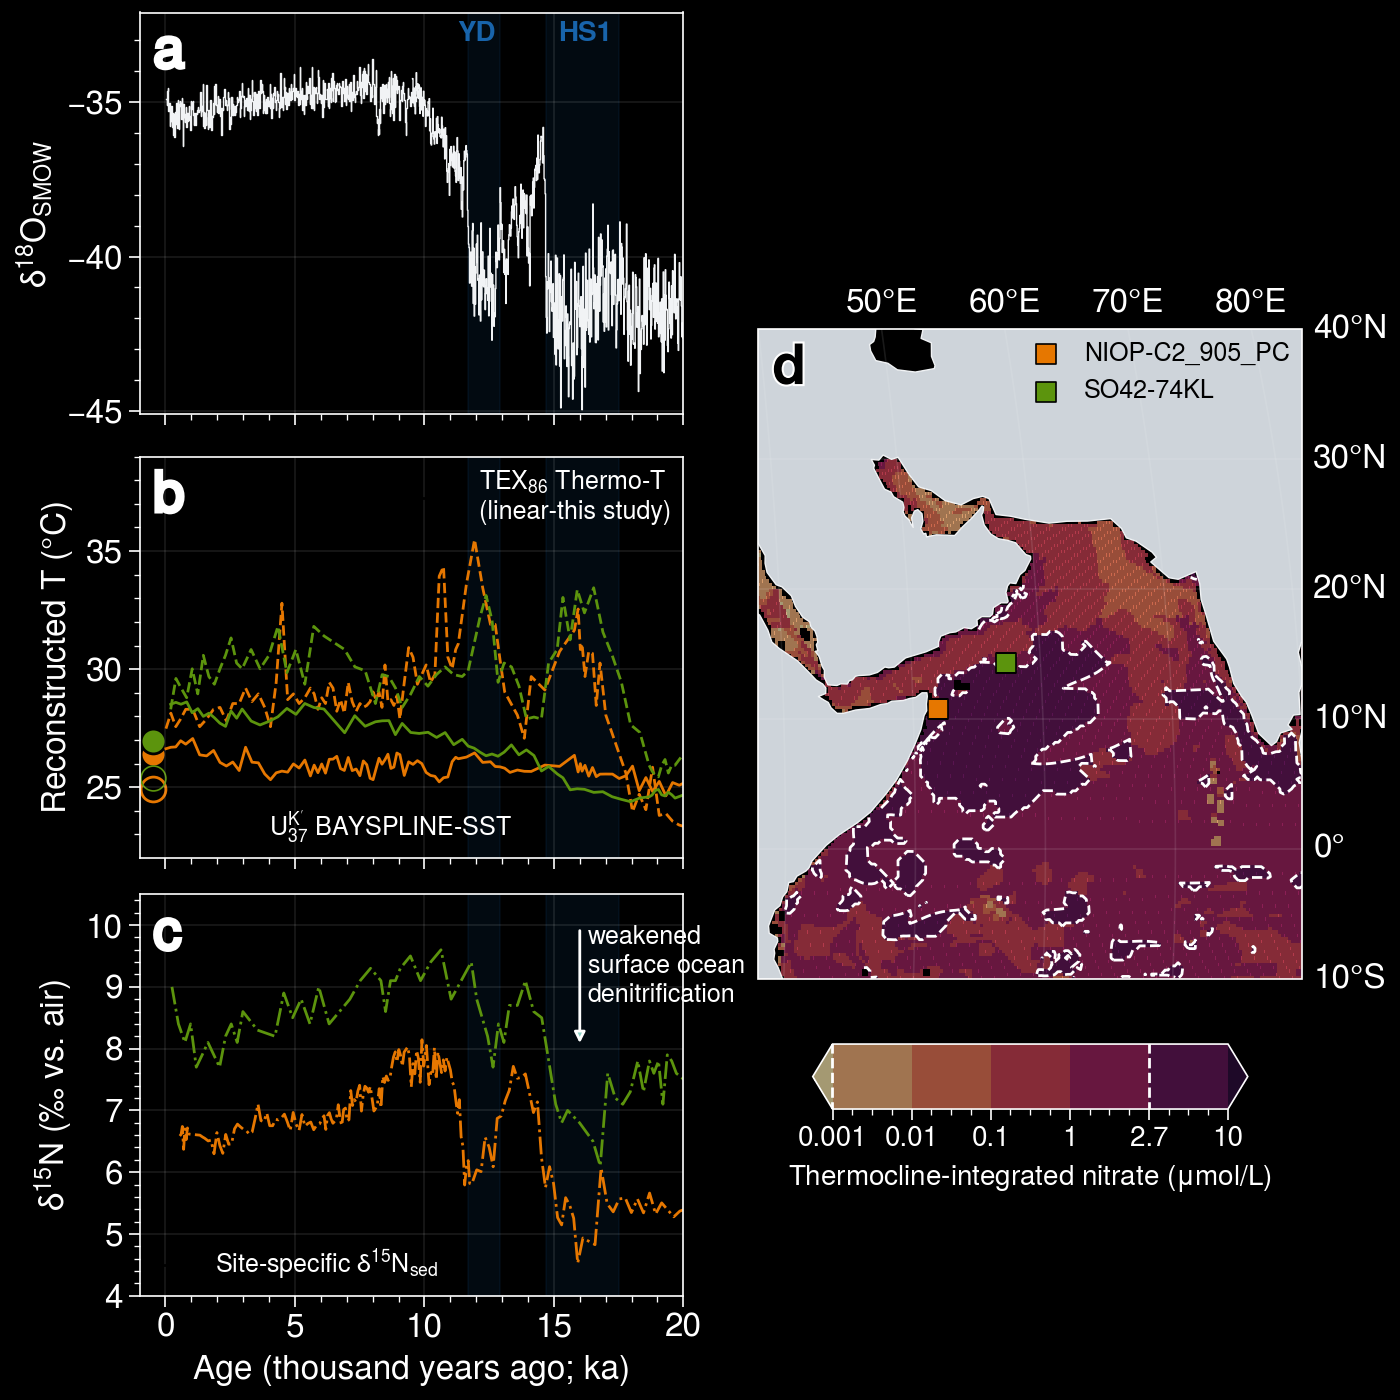

In [36]:
plot.rc['meta.color'] = 'w'

array = [
    [1,1,4,4],
    [2,2,4,4],
    [3,3,4,4],
]
fig, axs = plot.subplots(
    array,
    figsize=(7,7),
    share=0,
    wspace=3,
    proj=(None,None,None,'eck3')
    )

axs.format(facecolor='gray0',fontsize=12)
########## site locations
ax = axs[3]
ax.format(land=True,landcolor='gray4',landzorder=0,
          coast=True,coastcolor='gray1',coastlinewidth=0.5,
          latlim=(-10,40),lonlim=(40,80),
          latlabels='r',lonlabels='t',
          labelsize=12,latlines=10,lonlines=10,)


### lat lon for NIOP-C2_905_PC = 10.767N,51.95E
### lat lon for SO42-74KL = 14.321N, 57.347E
ax.scatter(51.95,10.767,c='yellow9',
           mec='k',marker='s',s=50,
           label='NIOP-C2_905_PC',
           zorder=2)

ax.scatter(57.347,14.321,c='lime9',
           mec='k',marker='s',s=50,
           label='SO42-74KL',
           zorder=2)
### plot sst and thermoT of modern sst for two core locations
NIOP905_today_sst = T_da.isel(depth=0).sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(-0.5,NIOP905_today_sst, c='yellow9', mec='k', mew=1, marker='o',s=80, clip_on=False)
NIOP905_today_thermoT = t_sf2tc_da.sel(lat=10.767,lon=51.95,method='nearest').values
axs[1].scatter(-0.5,NIOP905_today_thermoT, facecolor='none', mec='yellow9', mew=1, marker='o',s=80, clip_on=False)

SO42_today_sst = T_da.isel(depth=0).sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(-0.5,SO42_today_sst, c='lime9', mec='k', mew=1, marker='o',s=80, clip_on=False)
SO42_today_thermoT = t_sf2tc_da.sel(lat=14.321,lon=57.347,method='nearest').values
axs[1].scatter(-0.5,SO42_today_thermoT, facecolor='none', mec='lime9',marker='o',s=80, clip_on=False)

### plot modern d15N for arabian sea regions

plot_data = coretop_gridded_d15N_ds.sel(lat=slice(10,20),
                                        lon=slice(50,60)
                                        ).to_dataframe().dropna(subset=['d15N_mean']).reset_index()

m=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)).plot(ax=ax,
                                                                    zorder=0,
                                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                                    cmap='matter',
                                                                    add_colorbar=False,
                                                                    alpha=0.65,
                                                                    rasterized=True)
ax.set_title('')
### plot the lowno3_threshold μM contour line
m2=thermocline_nitrate_da.sel(lat=slice(-10,30),lon=slice(25,90)
                                       ).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                        zorder=1,
                                                        linewidths=1,
                                                        linestyles='dashed',
                                                        colors='w',robust=True)

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.2,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)

axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both'
             )
cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=10)
cbar.ax.tick_params(labelsize=10)
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')
axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])

###### time series plot
ax = axs[0]
ax.format(
    ylabel='$\delta^{18}$O$_{SMOW}$',
)
plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP1']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP1']
ax.plot(plot_x,plot_y,c='gray1',lw=0.5,label='NGRIP')

plot_data = ngrip_df.dropna(how='all',subset=['d18O NGRIP2']).reset_index(drop=True)
plot_x = plot_data['Age']/1000
plot_y = plot_data['d18O NGRIP2']
ax.plot(plot_x,plot_y,c='gray1',lw=0.5,label='')


ax = axs[1]
ax.format(
    ylabel='Reconstructed T ($\degree$C)',
    yticks=[25,30,35],
)
plot_data = NIOP905_SST_df
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='yellow9',lw=1)

plot_data = NIOP905_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='yellow9',ls='--',lw=1)

plot_data = SO42_75KL_SST_df 
plot_x = plot_data['Age_kaBP']
plot_y = plot_data['sst']
ax.plot(plot_x,plot_y,c='lime9',lw=1)

plot_data = SO42_75KL_tex_df
plot_x = plot_data['Age']*1000
plot_y2 = plot_data['SST']
ax.plot(plot_x,plot_y2,c='lime9',ls='--',lw=1)

#### plotting d15N data


ax = axs[2]
ax.format(
    ylabel='$\delta^{15}$N (‰ vs. air)',
    ylim=(4,10.5)
)
    
#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(16,10),xytext=(16,8),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(16.3,10,'weakened\nsurface ocean\ndenitrification',
        ha='left',va='top',fontsize=9)

sel_sites = ['NIOP 905','SO42-74KL']
sel_colors = ['yellow9','lime9']
plot_data = downcore_d15N_df[downcore_d15N_df['core_name'].isin(sel_sites)].dropna(subset=['Age','d15N'])
grouped = plot_data.groupby('core_name')
for name, group in grouped:
    group = group.sort_values(by='Age').reset_index(drop=True)
    plot_x = group['Age']
    plot_y = group['d15N']
    ax.plot(plot_x,plot_y,
            c=sel_colors[sel_sites.index(name)],
            lw=1,ls='-.',label='site-specific $\delta^{15}$N$_{sed}$')

#### add shaded area highlighting Younger Dryas (YD; 12.9-11.7 ka) and Heinrich stadial 1 (HS1; 16.9-14.5 ka) for all plots
for ax in axs[:3]:
    ax.axvspan(11.7,12.9,color='blue9',alpha=0.1)
    ax.axvspan(14.7,17.5,color='blue9',alpha=0.1)
### add text labels for YD and HS1 at the top of subplot A
ax = axs[0]
ax.text(0.62,0.98,'YD',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')
ax.text(0.82,0.98,'HS1',transform=ax.transAxes,
        ha='center',va='top',color='blue9',
        fontsize=10,fontweight='bold')



############################################################

h, l = axs[1].get_legend_handles_labels()
h2, l2 = axs[2].get_legend_handles_labels()
h3,l3 = axs[-1].get_legend_handles_labels()


axs[1].legend(h[1],loc='ur',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0,0,1,1),
              labels=['TEX$_{86}$ Thermo-T\n(linear-this study)'],
              fontsize=8,
              )
axs[1].legend(h[0],loc='ll',c='k',
              frameon=False,
              ncols=1,
              bbox_to_anchor=(0.1,0,1,1),
              labels=["U$^{K'}_{37}$ BAYSPLINE-SST"],
              fontsize=8,
              )


axs[2].legend([h2[i] for i in [1]],
              loc='ll',ncols=1,
              c='k',
              frameon=False,
              labels=['Site-specific $\delta^{15}$N$_{sed}$']
              )

axs[-1].legend(h3,loc='upper right',ncol=1,
               bbox_to_anchor=(0,0,1,1),
               labels=['NIOP-C2_905_PC','SO42-74KL'],
               labelcolor='k',
               frameon=False,)


## set the color for the first two marker elements as black

axs.format(abc=True,abcloc='ul',abcstyle='a',
           rc_kw={'abc.size':20,'abc.weight':'normal'},
           facecolor='none',
           gridcolor='w')

axs[:,0].format(
    xlim=(-1,20),
    xlabel='Age (thousand years ago; ka)',
)

axs[-1].format(rc_kw={'abc.color':'k','abc.weight':'bold'},)

axs[:2,0].format(
    xlabel='',
    xticklabels=[],
)
### set ylims for each plot
axs[0].format(ylim=(-45.1,-32.1),yticks=[-45,-40,-35])
axs[1].set_ylim(22,39)
plt.show()

fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_ArabianSea_presentation.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=330,
            transparent=True)

# Figure 4

In [26]:
fpath = fr'{local_github_path}/spreadsheets/'
fname = 'ds07_TasmanSea_paleorecords.xlsx'

slope = ols_tex_thermoT_thisStudy.coef_[0]
intercept = ols_tex_thermoT_thisStudy.intercept_

#################
DSDP591_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenones',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_Alkenones',skiprows=2).iloc[0,:].values
DSDP591_uk37_df.columns = header
DSDP591_uk37_df = DSDP591_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age','uk37','SST_bayspline','uk37_conc_ng_g']
DSDP591_uk37_df = DSDP591_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(DSDP591_uk37_df.head())

#################
DSDP591_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGTs',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='DSDP591_GDGTs',skiprows=2).iloc[0,:].values
DSDP591_tex86_df.columns = header

DSDP591_tex86_df = DSDP591_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                    'GDGTs':'gdgt_conc_ng_g'})
features = ['Depth_mbsf','Age','TEX86','BIT','MI','%GDGT-0',
            'TEX86H-derived SST','BAYSPAR-derived SST','gdgt_conc_ng_g']
DSDP591_tex86_df = DSDP591_tex86_df[features].dropna(subset=['TEX86','gdgt_conc_ng_g'])
DSDP591_tex86_df['sst_new'] = (DSDP591_tex86_df['TEX86']-intercept)/slope
display(DSDP591_tex86_df.head())

#################
IODPU1510_uk37_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenones',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_Alkenones',skiprows=2).iloc[0,:].values
IODPU1510_uk37_df.columns = header
IODPU1510_uk37_df = IODPU1510_uk37_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                  "UK37'":'uk37',
                                                  'BAYSPLINE-derived SST':'SST_bayspline',
                                                  "UK37 Total":'uk37_conc_ng_g'})
features = ['Depth_mbsf','Age','uk37','SST_bayspline','uk37_conc_ng_g']
IODPU1510_uk37_df = IODPU1510_uk37_df[features].dropna(subset=['uk37','SST_bayspline','uk37_conc_ng_g'])
display(IODPU1510_uk37_df.head())

################
IODPU1510_tex86_df = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGTs',skiprows=4)
## header is in line 3 of the excel sheet
header = pd.read_excel(os.path.join(fpath,fname),sheet_name='IODPU1510_GDGTs',skiprows=2).iloc[0,:].values
IODPU1510_tex86_df.columns = header
IODPU1510_tex86_df = IODPU1510_tex86_df.rename(columns={'Mid Depth':'Depth_mbsf',
                                                    'GDGTs':'gdgt_conc_ng_g'})
features = ['Depth_mbsf','Age','TEX86','BIT','MI','%GDGT-0',
            'TEX86H-derived SST','BAYSPAR-derived SST','gdgt_conc_ng_g']
IODPU1510_tex86_df = IODPU1510_tex86_df[features].rename(columns={'Mid Depth':'Depth_mbsf',})
IODPU1510_tex86_df['sst_new'] = (IODPU1510_tex86_df['TEX86']-intercept)/slope
display(IODPU1510_tex86_df.head())


,Depth_mbsf,Age,uk37,SST_bayspline,uk37_conc_ng_g
1,0.08,3.733333,0.780302,21.567039,60.142137
2,0.13,6.066667,0.782140,21.612052,55.215972
3,0.15,7.000000,0.778392,21.518875,42.346749
4,0.21,9.800000,0.758567,20.904653,51.550387
5,0.26,12.133333,0.751895,20.705976,51.653682


,Depth_mbsf,Age,TEX86,BIT,MI,%GDGT-0,TEX86H-derived SST,BAYSPAR-derived SST,gdgt_conc_ng_g,sst_new
0,0.015,0.700000,0.671171,0.069047,0.222435,35.965057,26.755403,28.201728,32.764723,27.903564
1,0.080,3.733333,0.642051,0.037590,0.221535,34.735051,25.437735,26.282491,15.966103,25.524841
2,0.130,6.066667,0.642196,0.053097,0.220875,31.220607,25.444456,26.414724,10.182232,25.536707
3,0.150,7.000000,0.654427,0.049686,0.225565,33.106594,26.004924,27.038865,5.306411,26.535839
4,0.210,9.800000,0.668655,0.240218,0.206030,33.489438,26.643825,28.100964,4.722384,27.698024


,Depth_mbsf,Age,uk37,SST_bayspline,uk37_conc_ng_g
0,0.07,1.465116,0.633501,17.126924,83.571324
1,0.26,5.441860,0.698090,19.083926,58.193295
2,0.39,8.162791,0.673087,18.333064,85.346620
3,0.48,10.046512,0.659800,17.927198,117.040424
4,0.60,12.558140,0.648789,17.605263,174.607923


,Depth_mbsf,Age,TEX86,BIT,MI,%GDGT-0,TEX86H-derived SST,BAYSPAR-derived SST,gdgt_conc_ng_g,sst_new
0,0.07,1.465116,0.557329,0.028901,0.202573,40.018913,21.234060,19.896243,41.740885,18.604409
1,0.26,5.441860,0.605109,0.285887,0.211529,39.180328,23.677416,23.084513,13.579156,22.507270
2,0.39,8.162791,0.586678,0.221950,0.218698,39.879790,22.758566,21.744193,29.976034,21.001774
3,0.48,10.046512,0.584390,0.068079,0.202950,37.339231,22.642486,21.744478,111.254399,20.814872
4,0.60,12.558140,0.557171,0.093141,0.238187,43.778182,21.225638,19.951818,116.056611,18.591504


In [27]:
### read LR04_benthic_stack data
fpath = fr'{local_github_path}/spreadsheets/published_data'
fname = 'lisiecki2005-d18o-stack-noaa.txt'
with open(os.path.join(fpath,fname),'r') as f:
    lines = f.readlines()
    
for i,line in enumerate(lines):
    if not line.startswith('#'):
        break
    
data = lines[i+1:]
header = ['Age_kyrBP','d18O_benthic','d18O_benthic_error']
data = [line.split() for line in data]
LR04_benthic_df = pd.DataFrame(data,columns=header)
LR04_benthic_df = LR04_benthic_df.apply(pd.to_numeric,errors='ignore')
LR04_benthic_df

/tmp/ipykernel_5731/1598268675.py:15: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  LR04_benthic_df = LR04_benthic_df.apply(pd.to_numeric,errors='ignore')


,Age_kyrBP,d18O_benthic,d18O_benthic_error
0,0.0,3.23,0.03
1,1.0,3.23,0.04
2,2.0,3.18,0.03
3,3.0,3.29,0.03
4,4.0,3.30,0.03
...,...,...,...
2110,5300.0,2.91,0.06
2111,5305.0,2.79,0.04
2112,5310.0,2.79,0.09
2113,5315.0,2.84,0.07


20.96759
18.09761


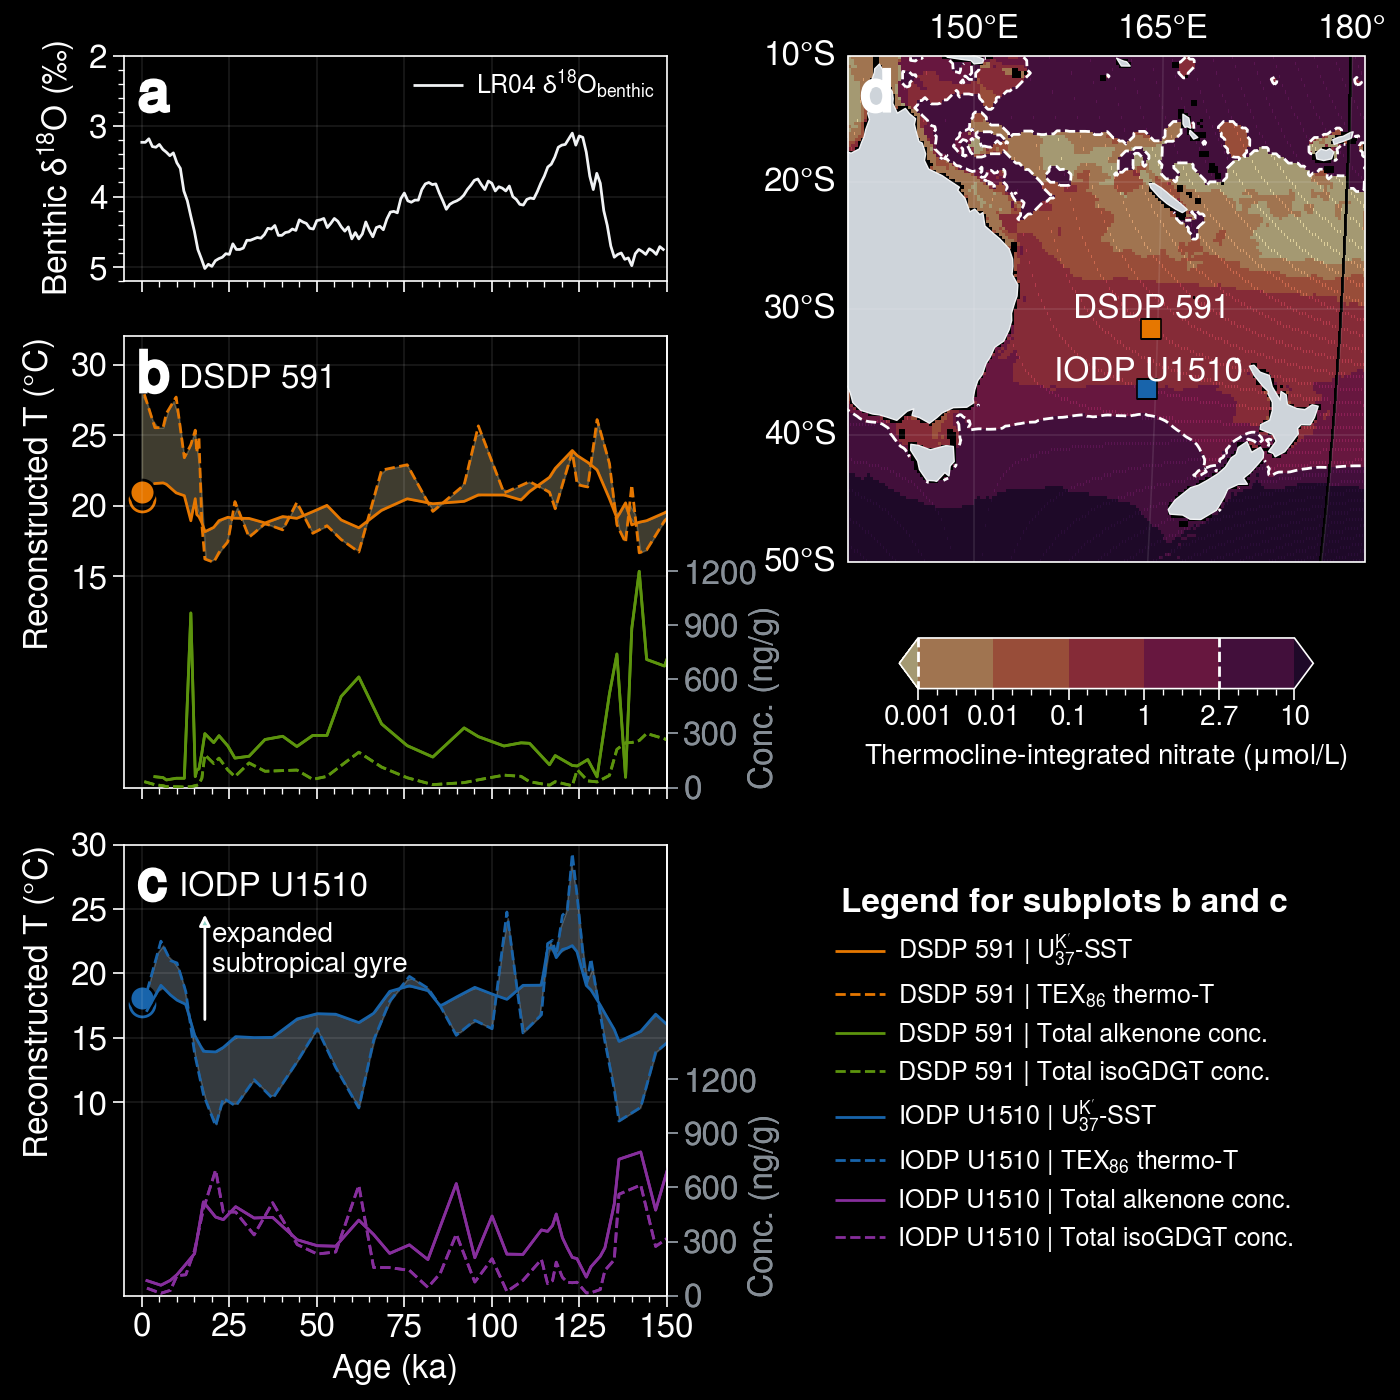

In [37]:

array = [
    [1,1,4,4],
    [2,2,4,4],
    [2,2,0,0],
    [3,3,0,0],
    [3,3,0,0],
]
fig, axs = plot.subplots(
    array,
    figsize=(7,7),
    share=0,
    proj=(None,None,None,'eck3'),
    proj_kw={'lon_0': 150}
    )
axs.format(facecolor='gray0',fontsize=12)
#### plot LR04 benthic d18O
ax = axs[0]

plot_data = LR04_benthic_df[LR04_benthic_df['Age_kyrBP']<150]
plot_x = plot_data['Age_kyrBP']
plot_y = plot_data['d18O_benthic']
ax.plot(plot_x,plot_y,lw=1,c='gray1',label = 'LR04 $\delta^{18}$O$_{benthic}$')
ax.format(
    ylim=(5.2,2.0),
    ylabel='Benthic $\delta^{18}$O (‰)',
)

h, l = ax.get_legend_handles_labels()
ax.legend(h,l,loc='ur',ncol=2,frameon=False,fontsize=12)
#### plot uk37-SST and tex86-SST as line plots on the same subplot for comparison 

ax = axs[1]
ax2 = ax.twinx()
plot_data = DSDP591_uk37_df.dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['uk37_conc_ng_g']
# ax2.fill_between(plot_x, plot_y, 0, color='gray4',lw=1,label='')
ax2.plot(plot_x, plot_y, color='lime9',lw=1, label='DSDP 591 | Total alkenone conc.')

plot_data = DSDP591_tex86_df.dropna(subset=['gdgt_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['gdgt_conc_ng_g']
ax2.plot(plot_x, plot_y, color='lime9',lw=1, ls='--', label='DSDP 591 | Total isoGDGT conc.')
ax2.format(
    ylim=(0,2500),
    yticks=np.arange(0,1201,300),  # Ensures major ticks span full range
    ytickminor=False,  # Consistent with ylim
    ytickcolor='gray6',
    ytickloc='right',
    yticklabelcolor='gray6',
    ylabelcolor='gray6',
    ylabel='Conc. (ng/g)',
    fontsize=12
)
ax2.yaxis.set_label_coords(1.15,0.2)

h2, l2 = ax2.get_legend_handles_labels()

plot_data = DSDP591_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age').reset_index(drop=True)
plot_x1 = plot_data['Age']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label="DSDP 591 | U$^{K'}_{37}$-SST",c='yellow9',lw=1)

plot_data = DSDP591_tex86_df[
    ((DSDP591_tex86_df['BIT']<=0.5)
    &(DSDP591_tex86_df['MI']<=0.5)
    &(DSDP591_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age').reset_index(drop=True)
plot_x2 = plot_data['Age']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='DSDP 591 | TEX$_{86}$ thermo-T', lw=1, ls='--', c='yellow9')


### shade color between y of two lines ---if tex is higher than uk37, shade red else shade blue
### need to interpolate the two lines to get the y values at the same x

x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='yellow1',alpha=0.25)


h, l = ax.get_legend_handles_labels()
ax.text(0.1,0.94,'DSDP 591',transform=ax.transAxes,
        ha='left',va='top',fontsize=12)
ax.format(
    ylim=(0,32),
    ytickrange=(15,30,5),
    ytickminor=False,
    yticks=[15,20,25,30],
    ylabel='Reconstructed T ($\degree$C)',
)
ax.yaxis.set_label_coords(-0.125,0.65)
#####################################################
ax = axs[2]
ax2 = ax.twinx()
plot_data = IODPU1510_uk37_df[IODPU1510_uk37_df['uk37_conc_ng_g']<8000
                              ].dropna(subset=['uk37_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['uk37_conc_ng_g']
# ax2.fill_between(plot_x, plot_y-10, color='gray3',lw=1,label='')
ax2.plot(plot_x, plot_y, color='grape9',lw=1, label='IODP U1510 | Total alkenone conc.')

plot_data = IODPU1510_tex86_df.dropna(subset=['gdgt_conc_ng_g']).sort_values(by='Age').reset_index(drop=True)
plot_x = plot_data['Age']
plot_y = plot_data['gdgt_conc_ng_g']
ax2.plot(plot_x, plot_y, color='grape9',lw=1, ls='--', label='IODP U1510 | Total isoGDGT conc.')
ax2.format(
    ylim=(0,2500),
    yticks=np.arange(0,1201,300),  # Ensures major ticks span full range
    ytickminor=False,  # Consistent with ylim
    ytickcolor='gray6',
    ytickloc='right',
    yticklabelcolor='gray6',
    ylabelcolor='gray6',
    ylabel='Conc. (ng/g)',
    fontsize=12
)
ax2.yaxis.set_label_coords(1.15,0.2)
h4, l4 = ax2.get_legend_handles_labels()
# Turn on the frame for the twin axis, but then hide all 
# but the bottom spine
ax2.set_frame_on(True)
ax2.patch.set_visible(False)


plot_data = IODPU1510_uk37_df.dropna(subset=['SST_bayspline']).sort_values(by='Age').reset_index(drop=True)
plot_x1 = plot_data['Age']
plot_y1 = plot_data['SST_bayspline']
ax.plot(plot_x1,plot_y1,label="IODP U1510 | U$^{K'}_{37}$-SST", lw=1, c='blue9')

plot_data = IODPU1510_tex86_df[
    ((IODPU1510_tex86_df['BIT']<=0.5)
    &(IODPU1510_tex86_df['MI']<=0.5)
    &(IODPU1510_tex86_df['%GDGT-0']<=60))].dropna(subset=['sst_new']).sort_values(by='Age').reset_index(drop=True)
plot_x2 = plot_data['Age']
plot_y2 = plot_data['sst_new']
ax.plot(plot_x2,plot_y2,label='IODP U1510 | TEX$_{86}$ thermo-T', lw=1, ls='--', c='blue9')

### shade pale yellow between y of two lines
### need to interpolate the two lines to get the y values at the same x
x = np.linspace(0,150,100)
y1 = np.interp(x,plot_x1,plot_y1)
y2 = np.interp(x,plot_x2,plot_y2)
ax.fill_between(x,y1,y2,color='blue1',alpha=0.25)

h3, l3 = ax.get_legend_handles_labels()
legend = ax.legend(h+h2+h3+h4,l+l2+l3+l4,
          titlefontweight='bold',
          loc='r',frameon=False,
          bbox_to_anchor=(1,0,1,1),
          ncol=1)
legend.set_title('Legend for subplots b and c', prop={'size': 12,
                                                      'weight':'bold'})
ax.text(0.1,0.94,'IODP U1510',transform=ax.transAxes,
        ha='left',va='top',fontsize=12)

ax.format(
    ylim=(-5,30),
    ytickrange=(10,30,5),
    ytickminor=False,
    yticks=[10,15,20,25,30],
    ylabel='Reconstructed T ($\degree$C)',
)

#### add an arrow with annotation showing reduced denitrification during YD and HS1
ax.annotate('',
            xy=(18,16),xytext=(18,25),
            arrowprops=dict(arrowstyle='<|-',lw=1),
            ha='center',va='center',fontsize=8)
ax.text(20,24,'expanded\nsubtropical gyre',
        ha='left',va='top',fontsize=10)
ax.yaxis.set_label_coords(-0.125,0.65)

####################################################
ax = axs[3]
ax.format(
    land=True,landcolor='gray4',landzorder=0,
    coast=True,coastcolor='gray1',coastlinewidth=0.5,
    latlim=(-50,-10),lonlim=(-220,-179),
    latlines=10,lonlines=15,
    latlabels='l',lonlabels='t',
    labelsize=12,
)


### plot thermocline-integrated nitrate on the map
m = thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot(ax=ax,
                                                    zorder=0,
                                                    levels=[1e-3,1e-2,1e-1,1,lowno3_threshold,10],
                                                    cmap='matter',
                                                    add_colorbar=False,
                                                    alpha=0.65,
                                                    rasterized=True)


### plot contour line for lowno3_threshold μM nitrate
m2 = thermocline_nitrate_da.sel(lat=slice(-60,-10)).plot.contour(ax=ax,levels=[0,lowno3_threshold],
                                                zorder=1,
                                                linewidths=1,
                                                linestyles='dashed',
                                                colors='w',robust=True)

ax.set_title('')

axins1 = inset_axes(
    ax,
    width="80%",
    height="10%",
    loc="lower center",
    bbox_to_anchor=(0,-0.25,1,1),
    bbox_transform=ax.transAxes,
    borderpad=0
)
axins1.patch.set_alpha(0)
cbar = fig.colorbar(m,
             cax=axins1,
             orientation="horizontal",
             extend='both'
             )
cbar.set_label('Thermocline-integrated nitrate ($\mu$mol/L)', size=10)
cbar.ax.tick_params(labelsize=10)
cbar.add_lines(m2)
cbar.lines[0].set_linestyle('dashed')

axins1.xaxis.set_ticklabels(['0.001','0.01','0.1','1',f'{lowno3_threshold}','10'])
### lat/lon for DSDP591 = -31.5843	 164.4487
### lat/lon for IODP U1510 = 36°19.7385′S, 164°33.5220′E, water depth 1238 m

axs[-1:].scatter(164.4487,-31.5843,c='yellow9',
           mec='k',marker='s',s=50,
           label='DSDP591',
           zorder=2)
axs[-1:].text(164.4487,-30,'DSDP 591',
              ha='center',va='center',
              fontsize=12,transform=ccrs.PlateCarree(),
              c='w',zorder=3)

axs[-1:].scatter(164.33,-36.33,c='blue9',
              mec='k',marker='s',s=50,
              label='IODP U1510',
              zorder=2)

axs[-1:].text(164.33,-35,'IODP U1510',
              ha='center',va='center',
              fontsize=12,transform=ccrs.PlateCarree(),
              c='w',zorder=3)


#### plot today's SST from T_da and thermocline-integrated T data
DSDP591_today_sst = T_da.isel(depth=0).sel(lat=-31.5843,lon=164.4487,method='nearest').values
DSDP591_thermoT = t_sf2tc_da.sel(lat=-31.5843,lon=164.4487,method='nearest').values
axs[1].scatter(0,DSDP591_thermoT,mec='yellow9',mew=1,marker='o',facecolor='none',s=80)
axs[1].scatter(0,DSDP591_today_sst,c='yellow9',mec='k',mew=1,marker='o',s=80)
print(DSDP591_today_sst)

IODPU1510_today_sst = T_da.isel(depth=0).sel(lat=-36.33,lon=164.33,method='nearest').values
IODPU1510_thermoT = t_sf2tc_da.sel(lat=-36.33,lon=164.33,method='nearest').values
axs[2].scatter(0,IODPU1510_thermoT,mec='blue9',mew=1,marker='o',facecolor='none',s=80)
axs[2].scatter(0,IODPU1510_today_sst,c='blue9',mec='k',mew=1,marker='o',s=80)
print(IODPU1510_today_sst)


axs[:3].format(
    xlim=(-5,150),
    xlabel='Age (ka)',
)
axs[:2].format(
    xlabel='',
    xticklabels=[],
)

axs.format(
    abc=True,abcloc='ul',abcstyle='a',rc_kw={'abc.size':20,'abc.weight':'normal'},
    facecolor='none'
)


    
fpath = fr'{local_github_path}/figures/'
fname = 'paleo_showcase_SPSTG.png'
fig.savefig(os.path.join(fpath,fname),bbox_inches='tight',embed_fonts=True,dpi=660)

/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/ronnie-rattan/miniforge3/envs/nutrient-effect-on-tex/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


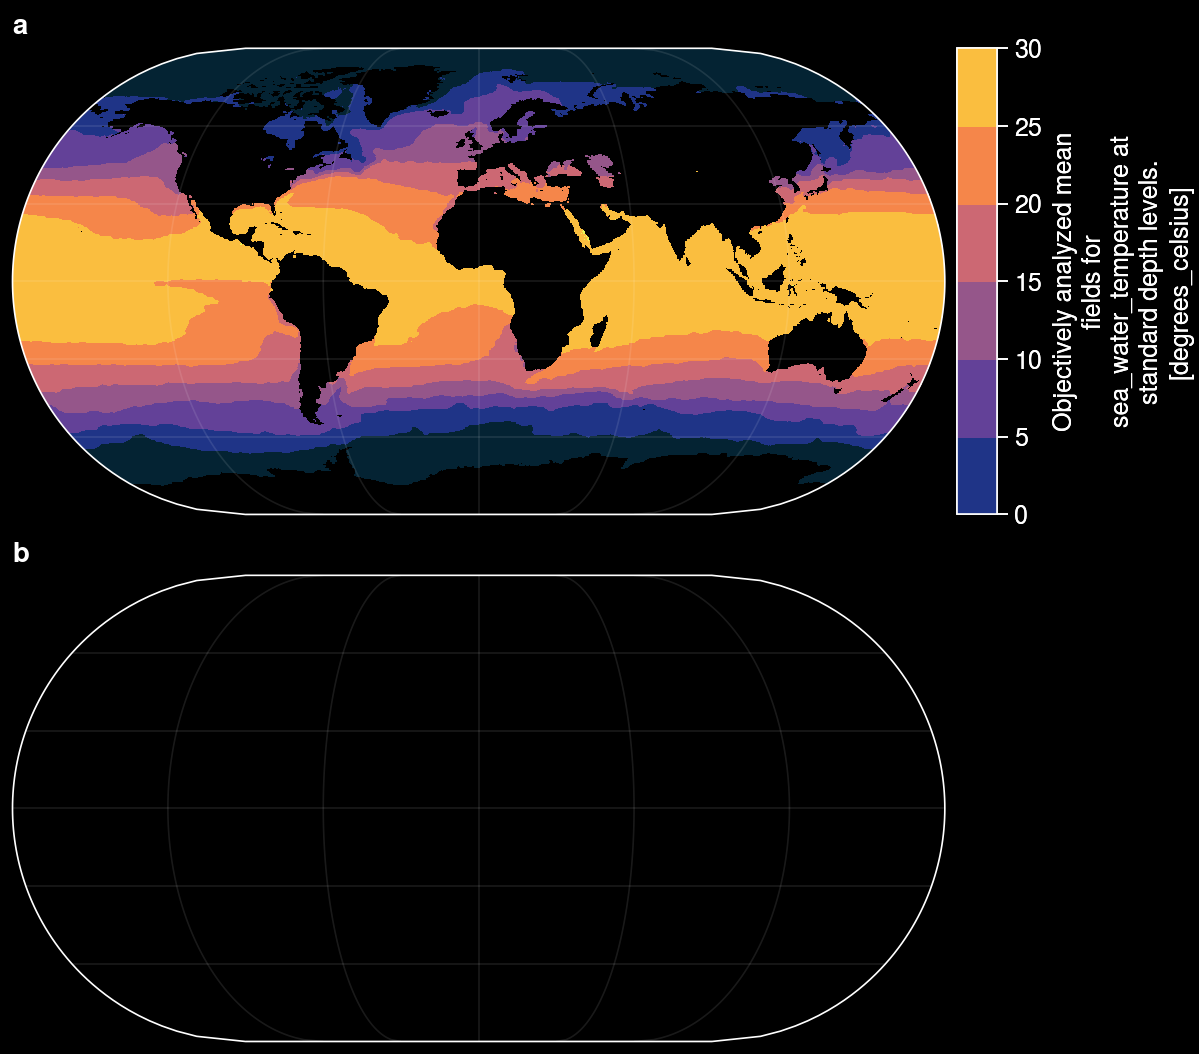

In [29]:
fig, axs = plot.subplots(nrows = 2, proj='eck3',width=6)

### plot WOA23 SST
ax = axs[0]
m = T_da.isel(depth=0).plot(ax=ax,
                        cmap='cmo.thermal',
                        levels=np.arange(0,30.1,5),
                        extend='both',)